In [1]:
import pickle 
from pathlib import Path 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# load precalculated embeddings

In [2]:
DATA_DIR = Path().absolute().parent / 'data'

with open(DATA_DIR / 'embeddings.pickle', 'rb') as f:
    embeddings_deepface = pickle.load(f)

with open(DATA_DIR / 'embeddings_insightface_v3_128x128.pickle', 'rb') as f:
    embeddings_insightface = pickle.load(f)

embeddings = embeddings_deepface | embeddings_insightface
print(embeddings.keys())

dict_keys(['VGG-Face', 'OpenFace', 'Facenet', 'Facenet512', 'DeepFace', 'DeepID', 'Dlib', 'ArcFace', 'SFace', 'buffalo_s', 'buffalo_sc', 'buffalo_m', 'buffalo_l', 'antelopev2'])


In [3]:
def dict2df(model_dict):
    embeddings = []
    labels = []
    is_fake = []
    fnames = []
    for label, embedding in model_dict.items():
        for fname, emb in embedding.items():
            if label == "ck":
                is_fake.append(1)
                labels.append(fname.split(".")[0])
            else:
                is_fake.append(0)
                labels.append(label)
            embeddings.append(np.array(emb["embedding"]))
            fnames.append(fname)
    df = pd.DataFrame({
    "embeddings": embeddings, 
    "labels": labels,
    "fnames": fnames,
    "is_fake": is_fake
    })
    return df

model2df = {model: dict2df(model_dict) for model, model_dict in embeddings.items()}
model2df["Facenet"].head()

embeddings    labels  \
0  [-1.4944489002227783, -1.4114049673080444, -0....  dr_house   
1  [-1.9788538217544556, -1.7696497440338135, -0....  dr_house   
2  [-2.5532069206237793, -0.7926962375640869, -0....  dr_house   
3  [-1.2020866870880127, -1.5620497465133667, -0....  dr_house   
4  [-3.0435636043548584, -2.2254717350006104, -0....  dr_house   

             fnames  is_fake  
0  008_ecae6a22.jpg        0  
1  002_3299cc32.jpg        0  
2  004_00999bba.jpg        0  
3  003_e525969e.jpg        0  
4  009_25abfef1.jpg        0

VGG-Face
(117, 2622)
(117, 117)


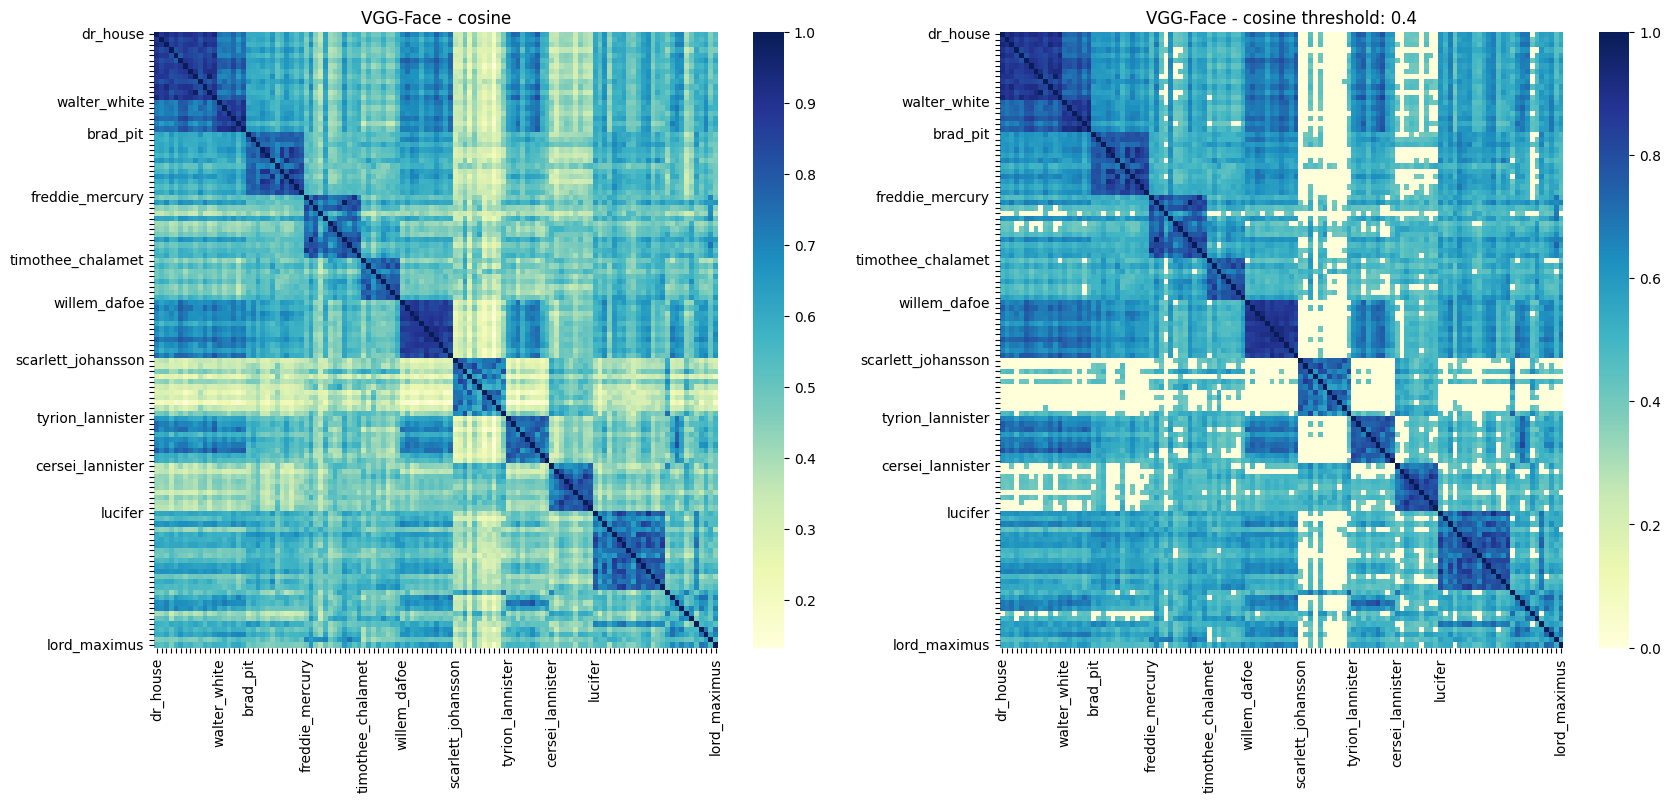

(117, 117)


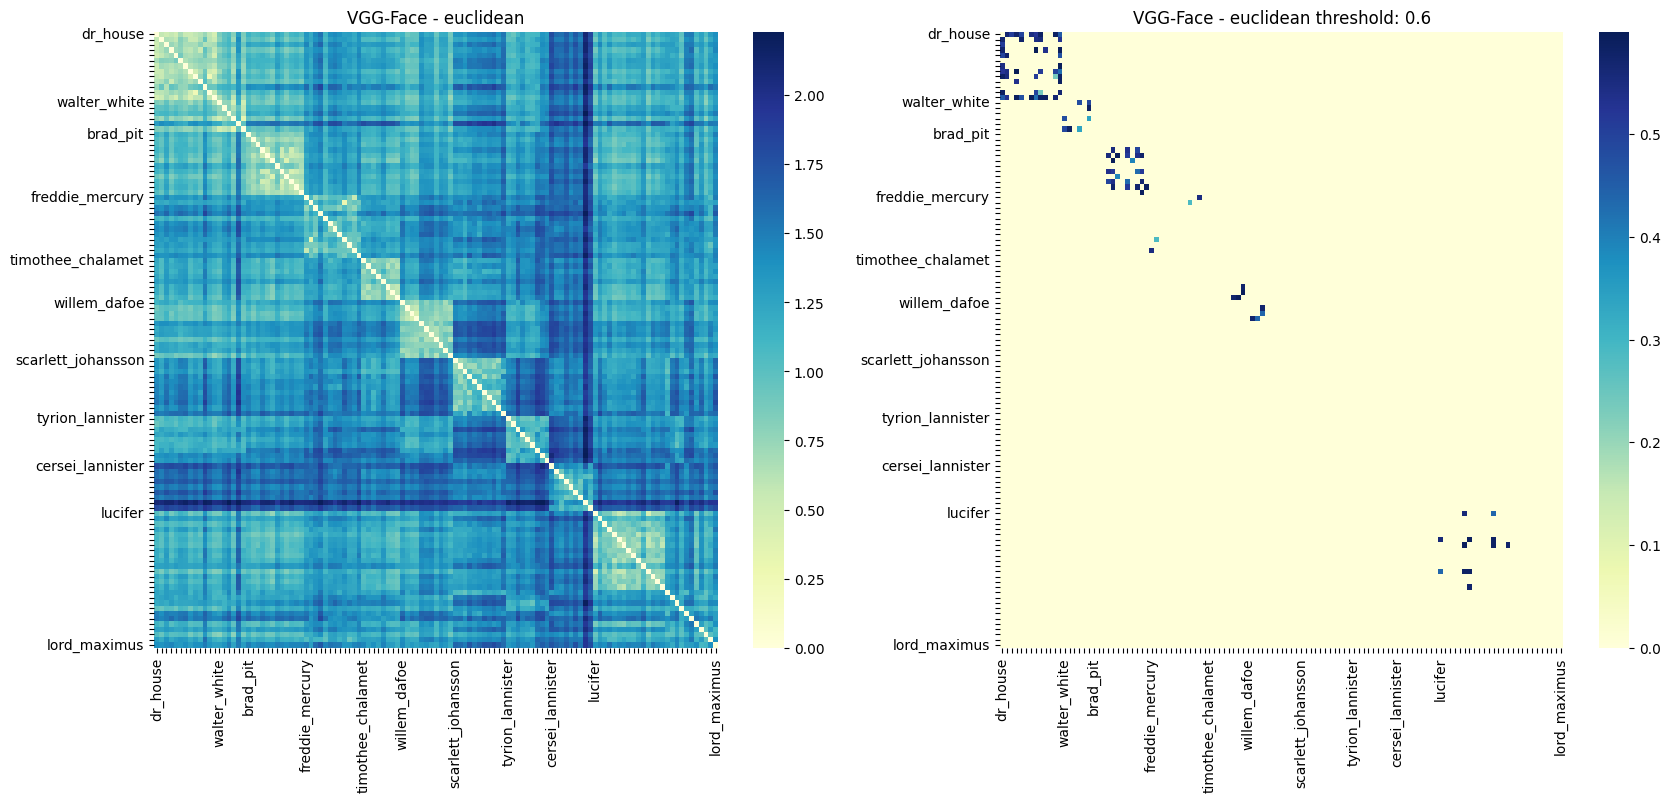

OpenFace
(117, 128)
(117, 117)


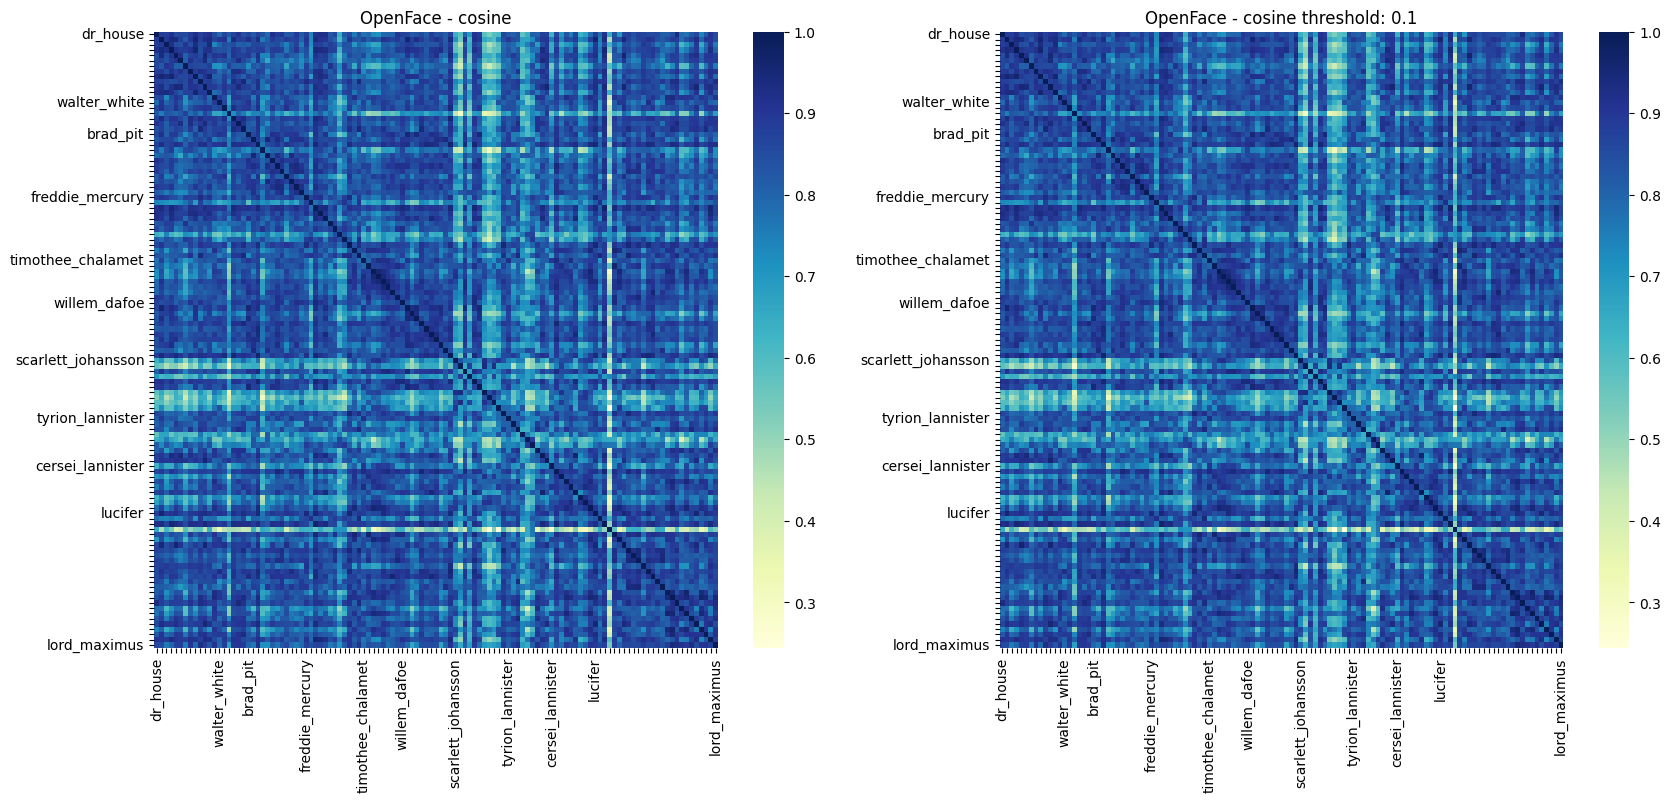

(117, 117)


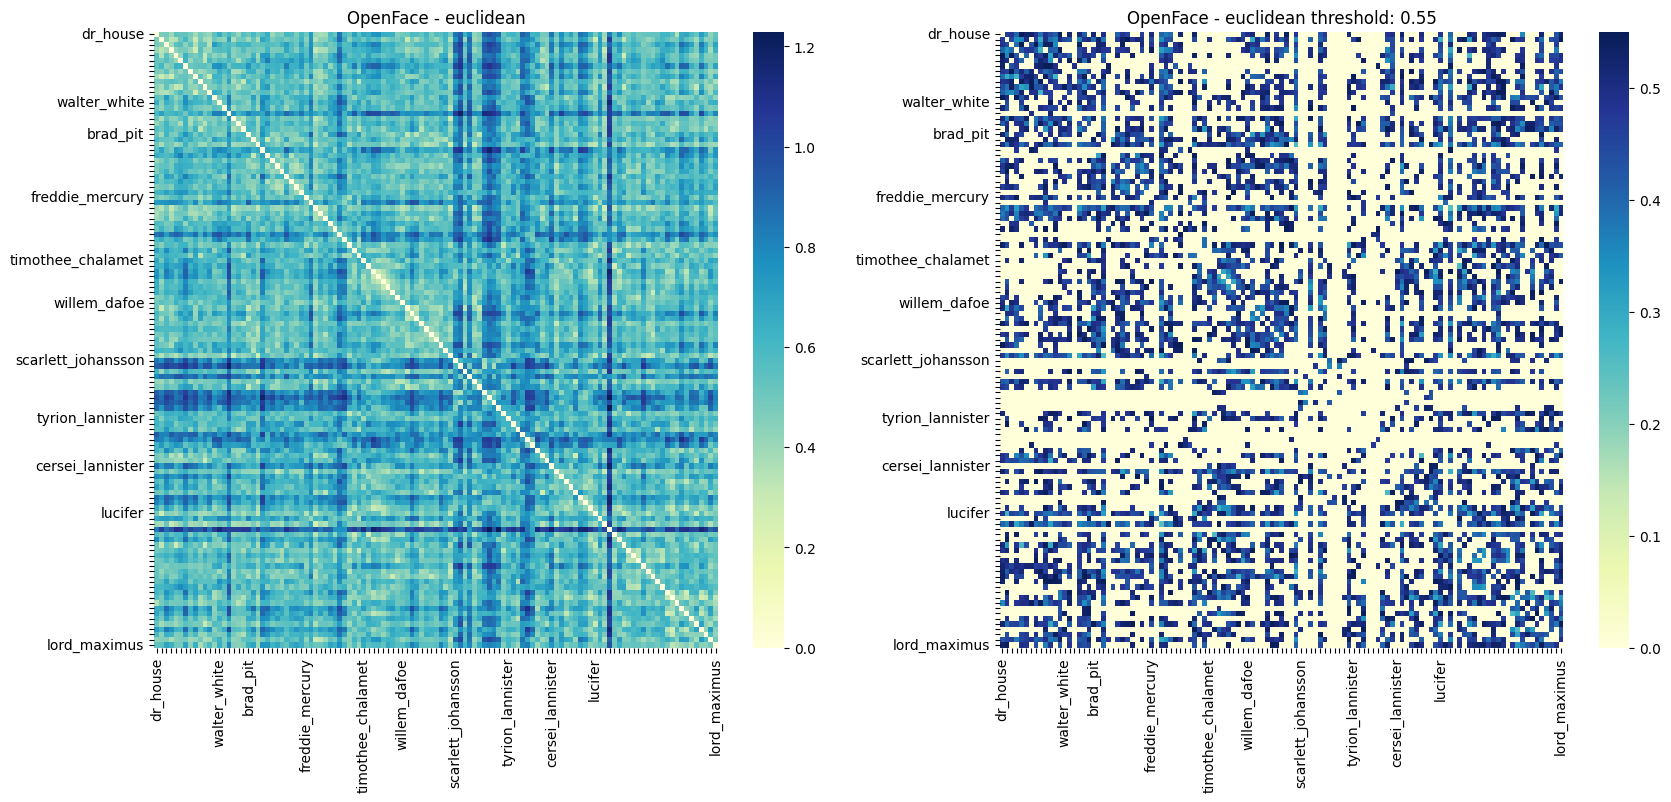

Facenet
(117, 128)
(117, 117)


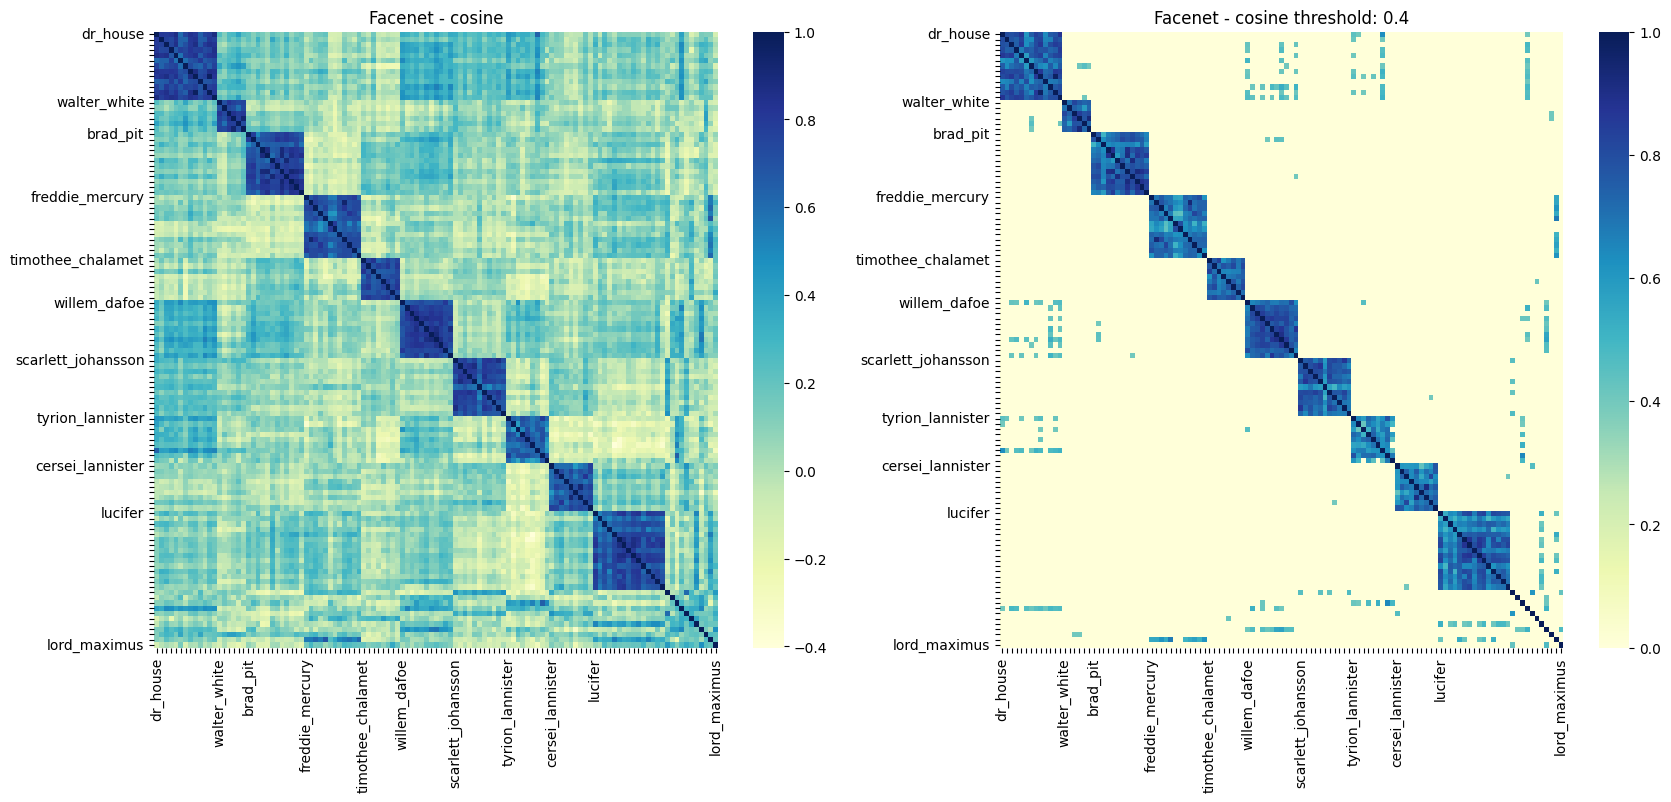

(117, 117)


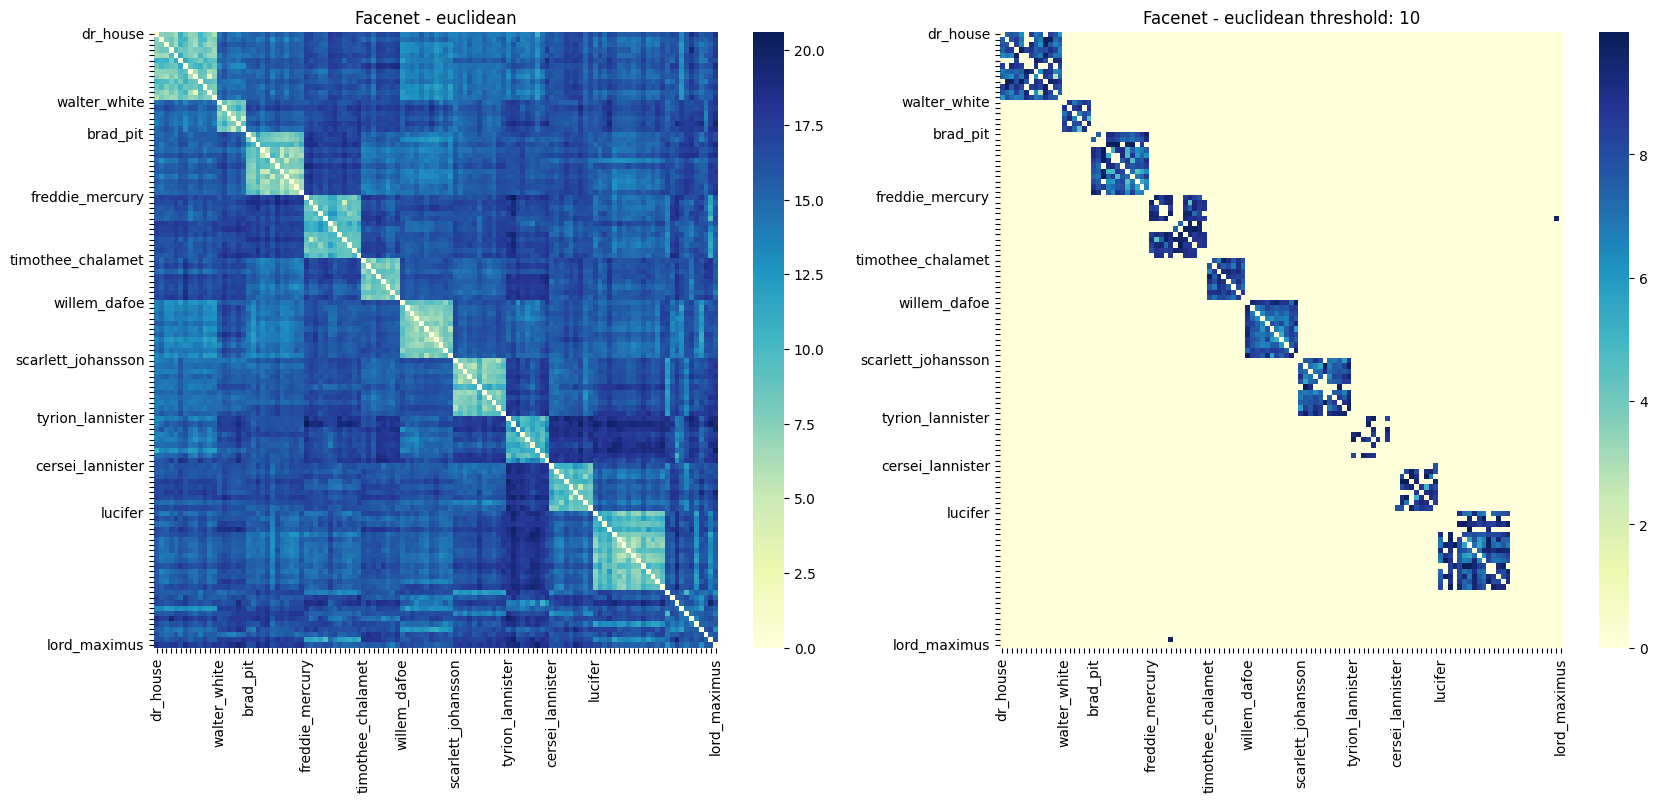

Facenet512
(117, 512)
(117, 117)


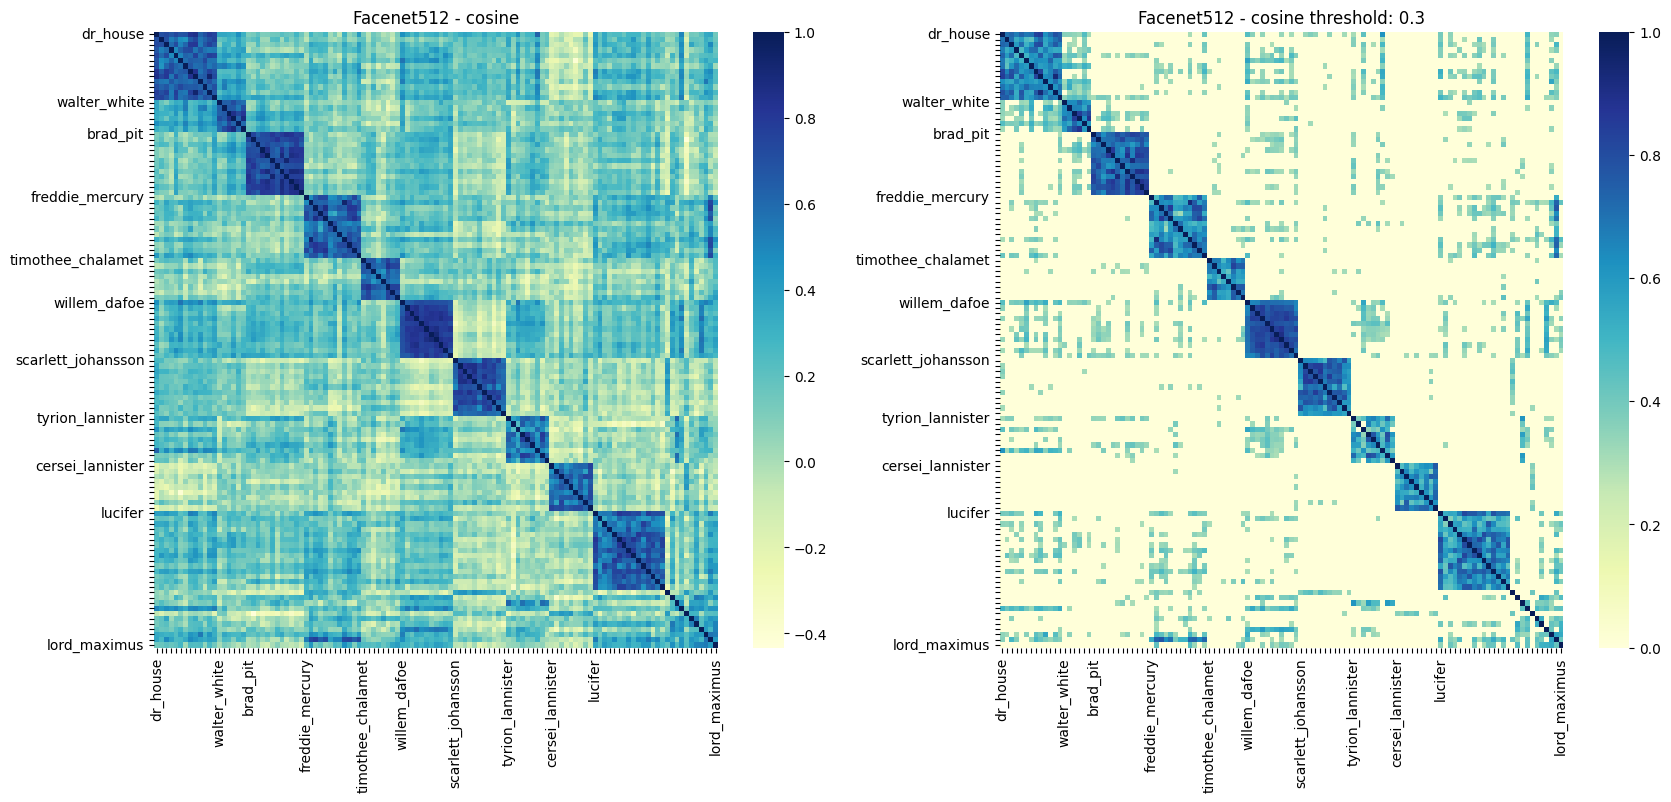

(117, 117)


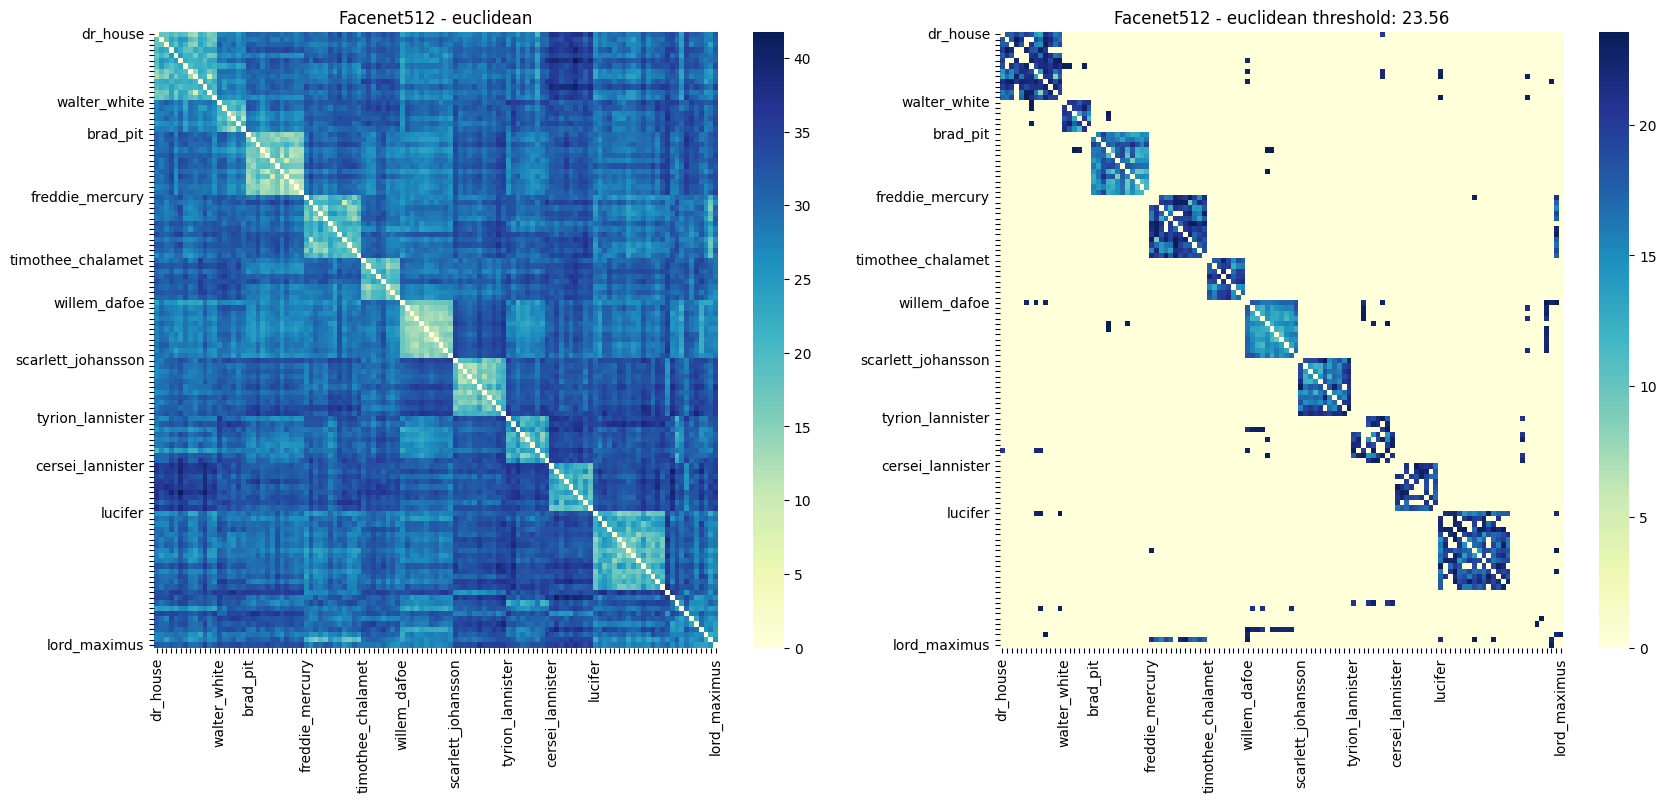

DeepFace
(117, 4096)
(117, 117)


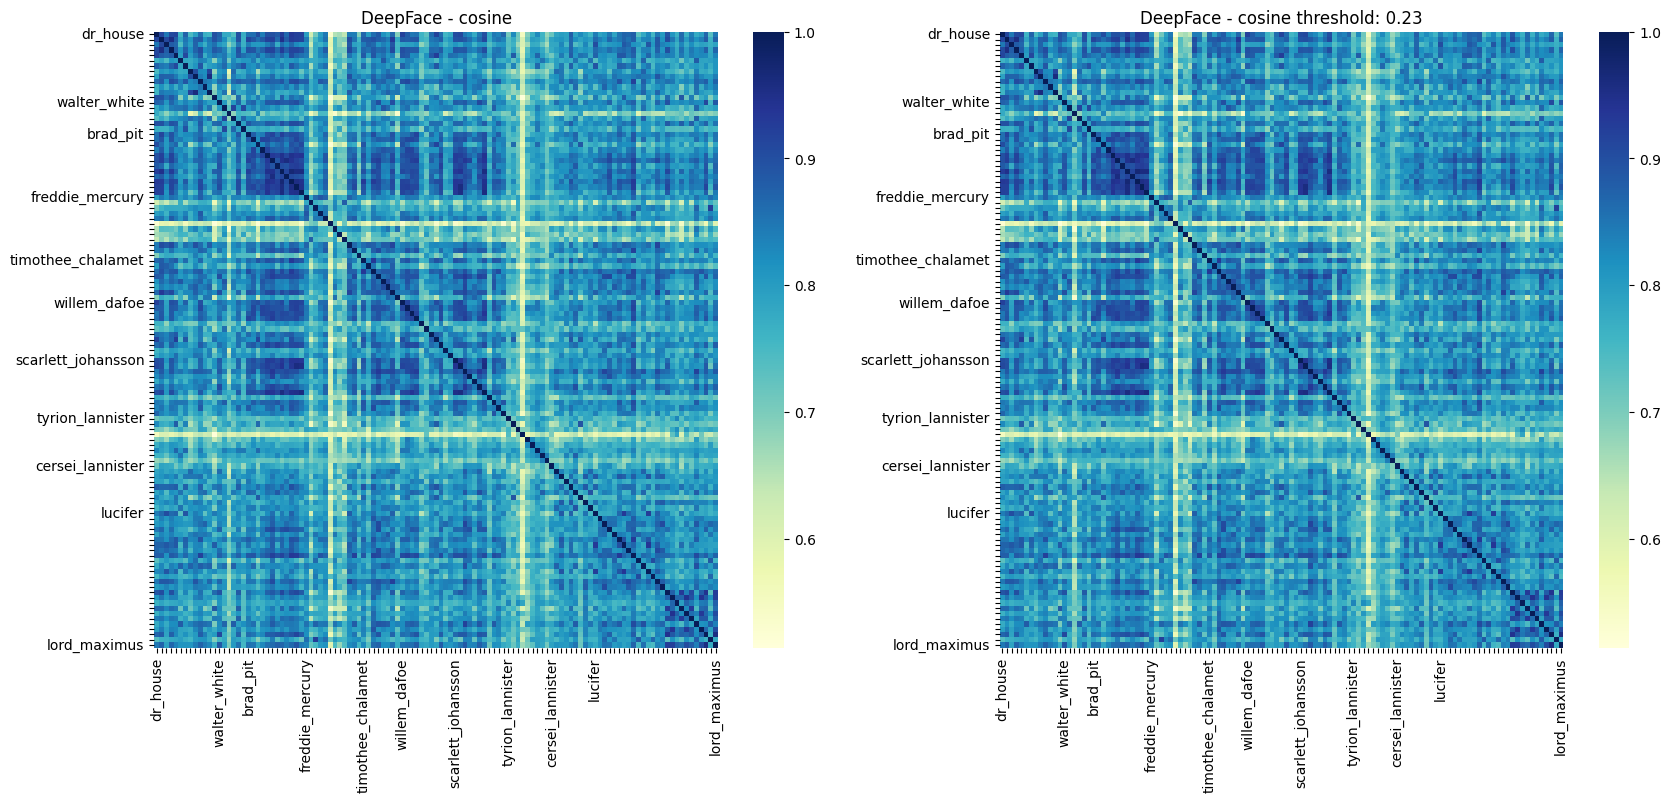

(117, 117)


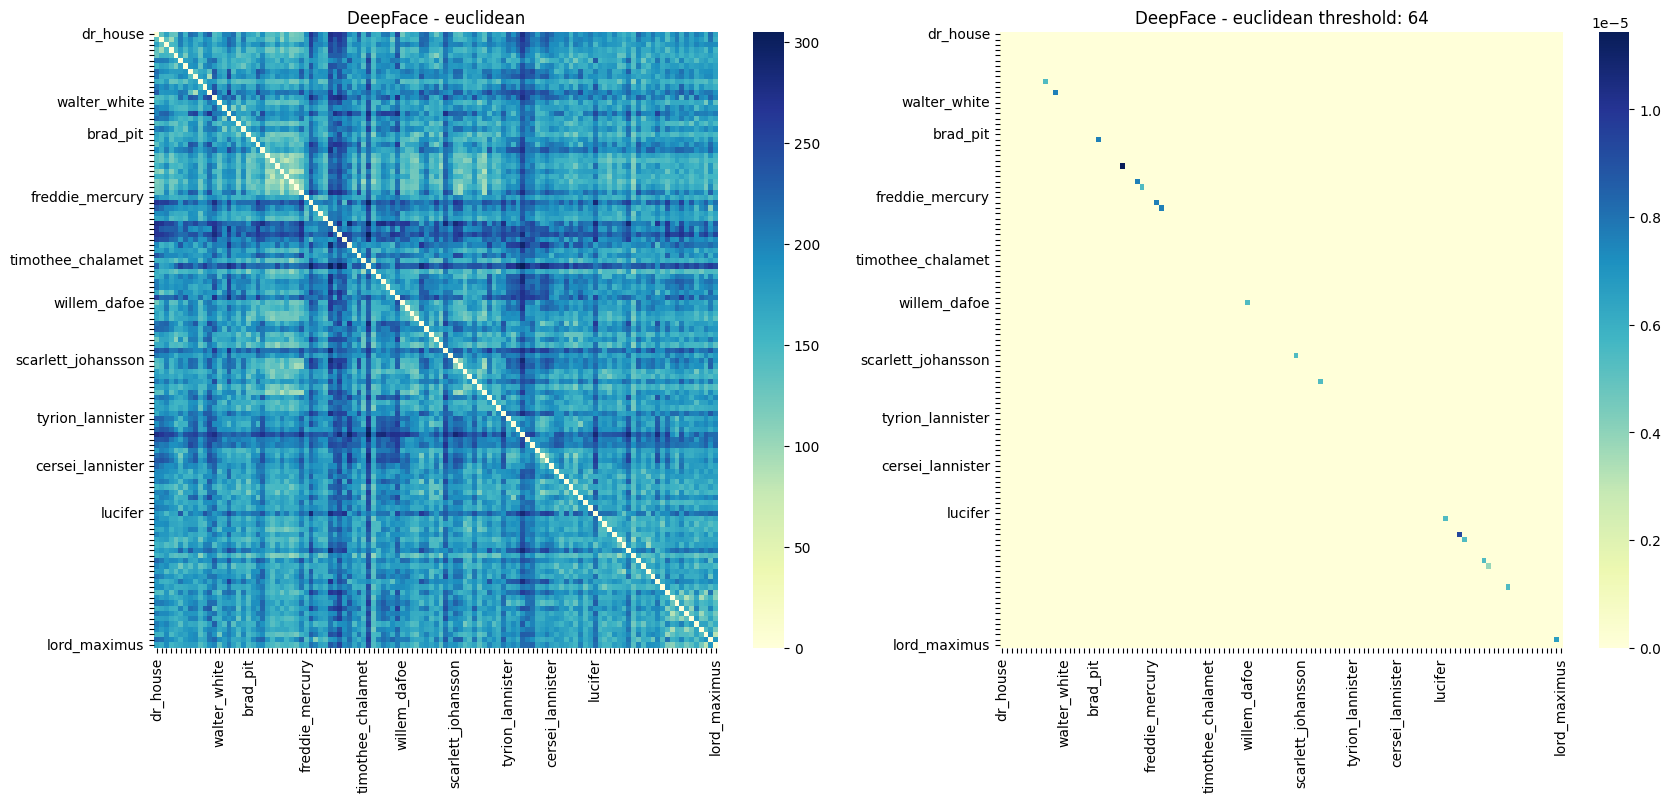

DeepID
(117, 160)
(117, 117)


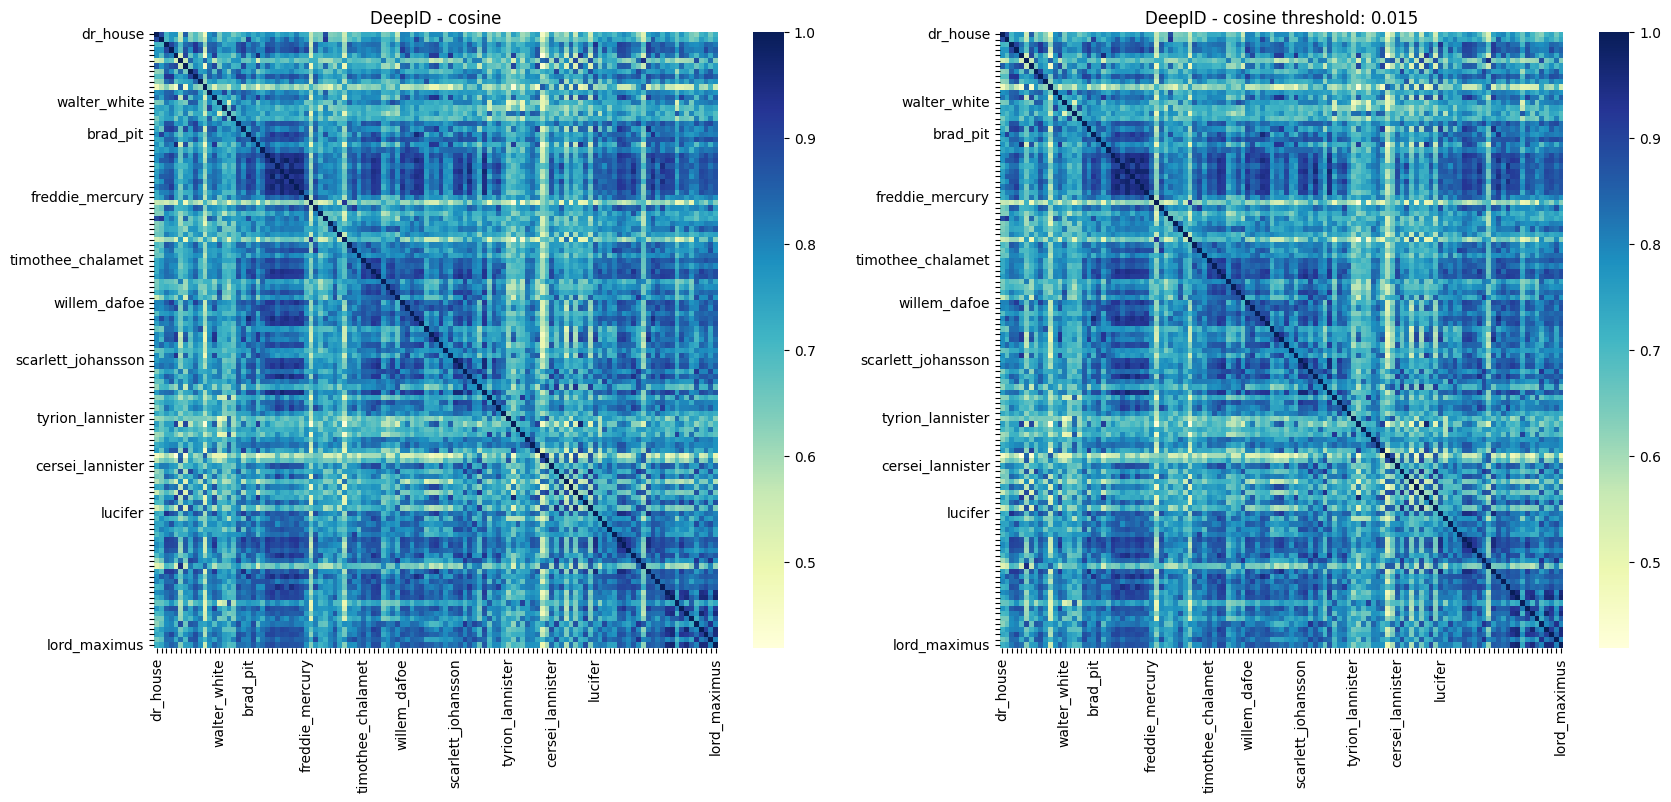

(117, 117)


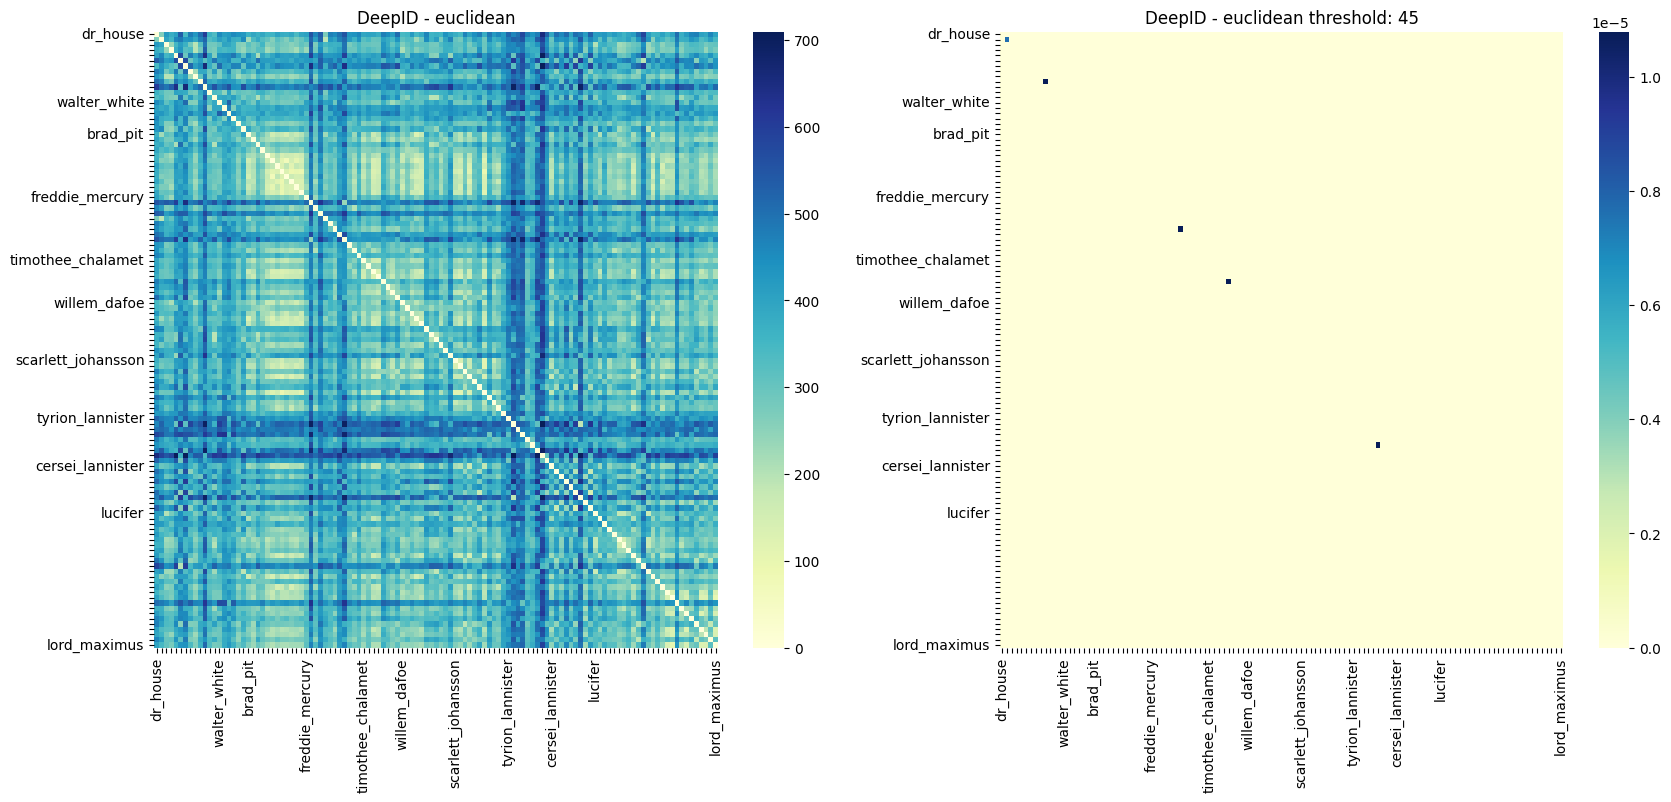

Dlib
(117, 128)
(117, 117)


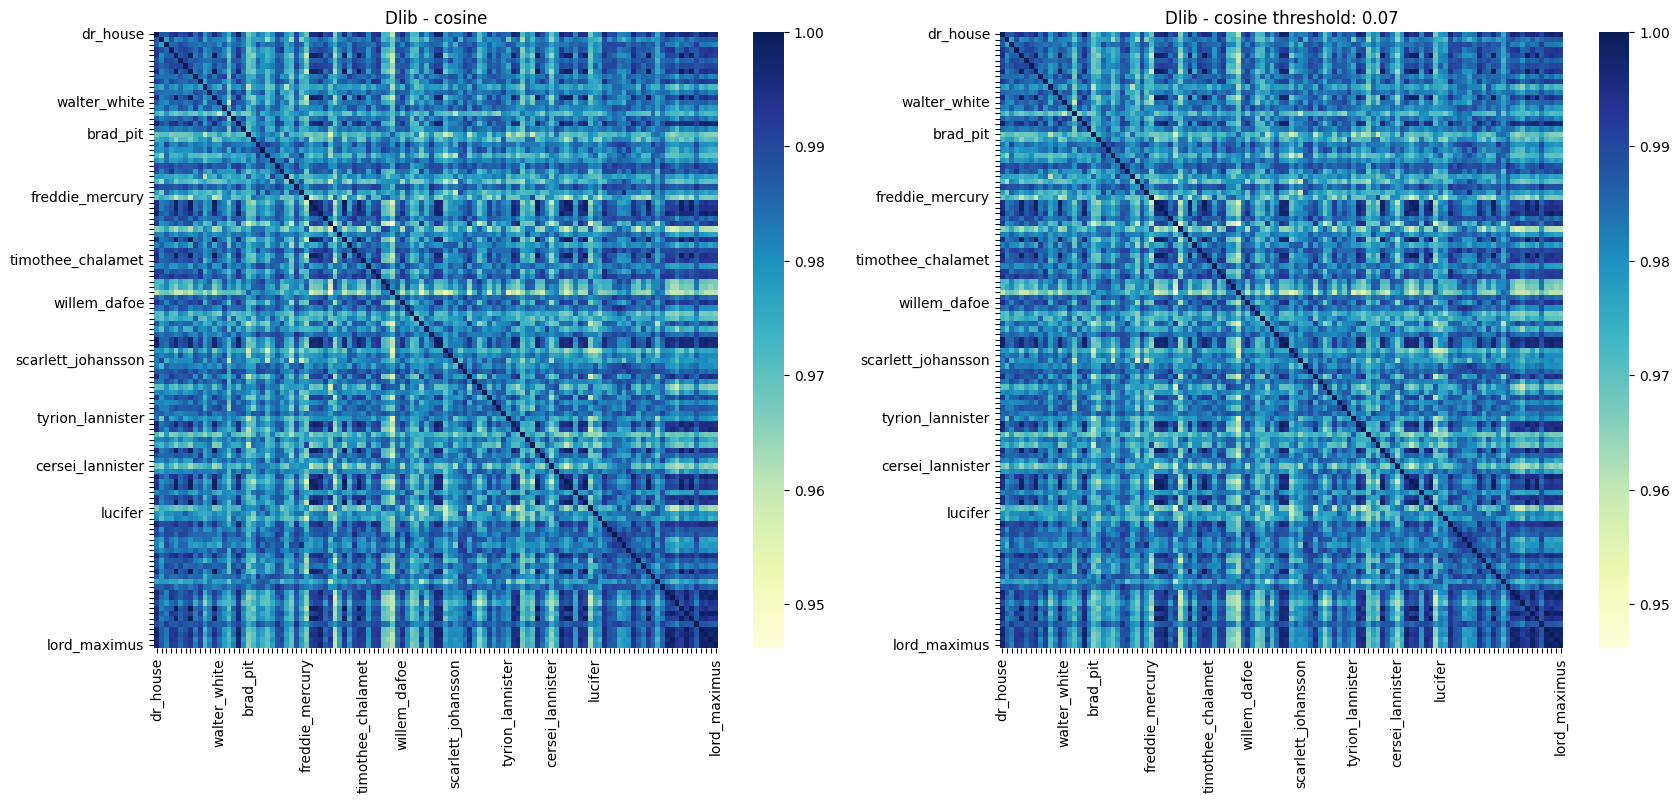

(117, 117)


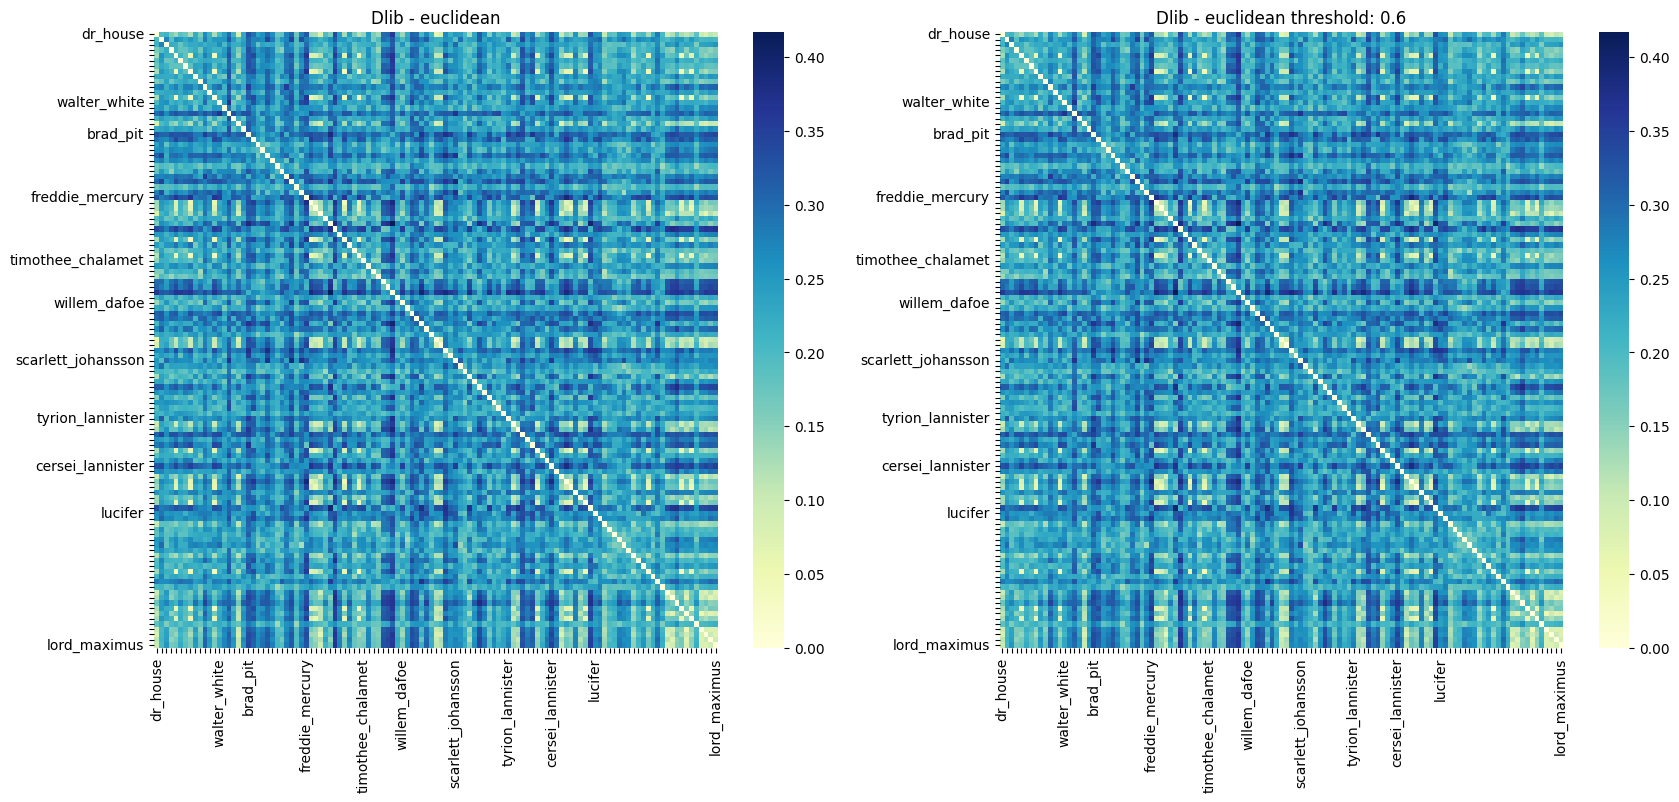

ArcFace
(117, 512)
(117, 117)


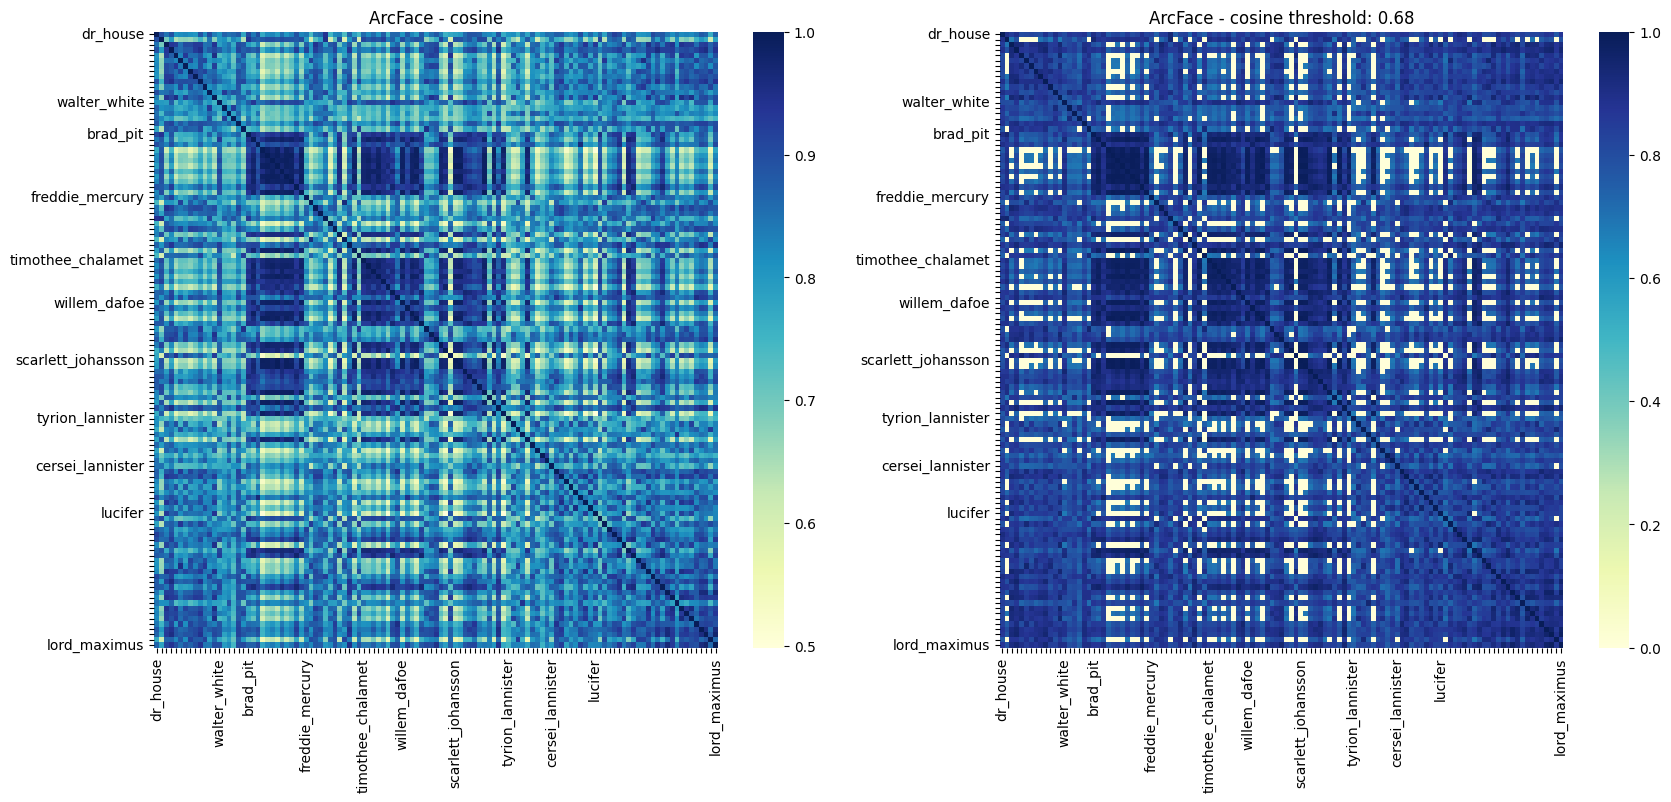

(117, 117)


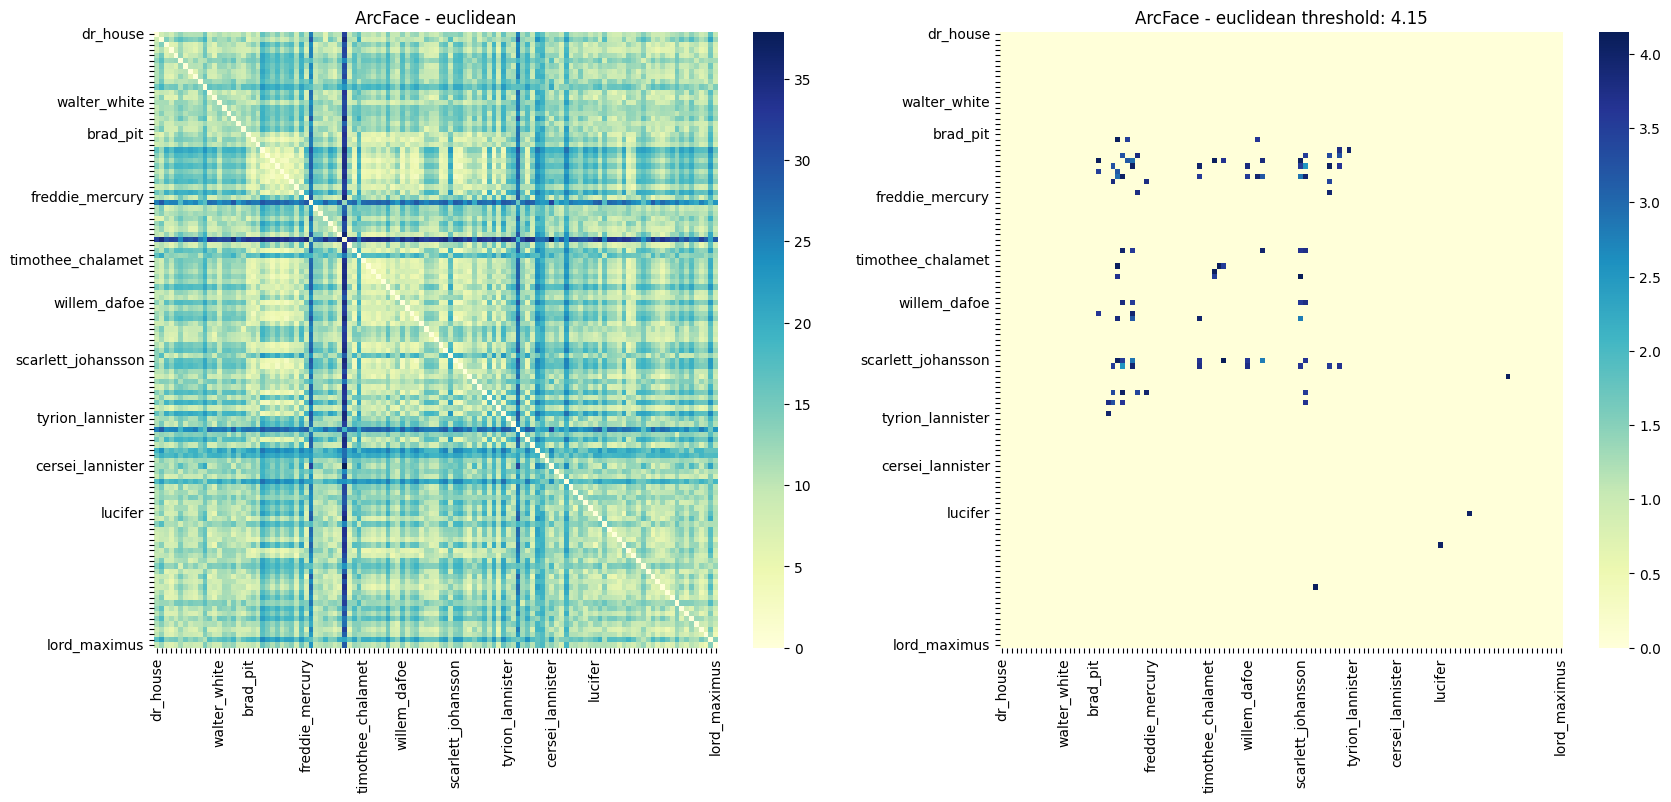

SFace
(117, 128)
(117, 117)


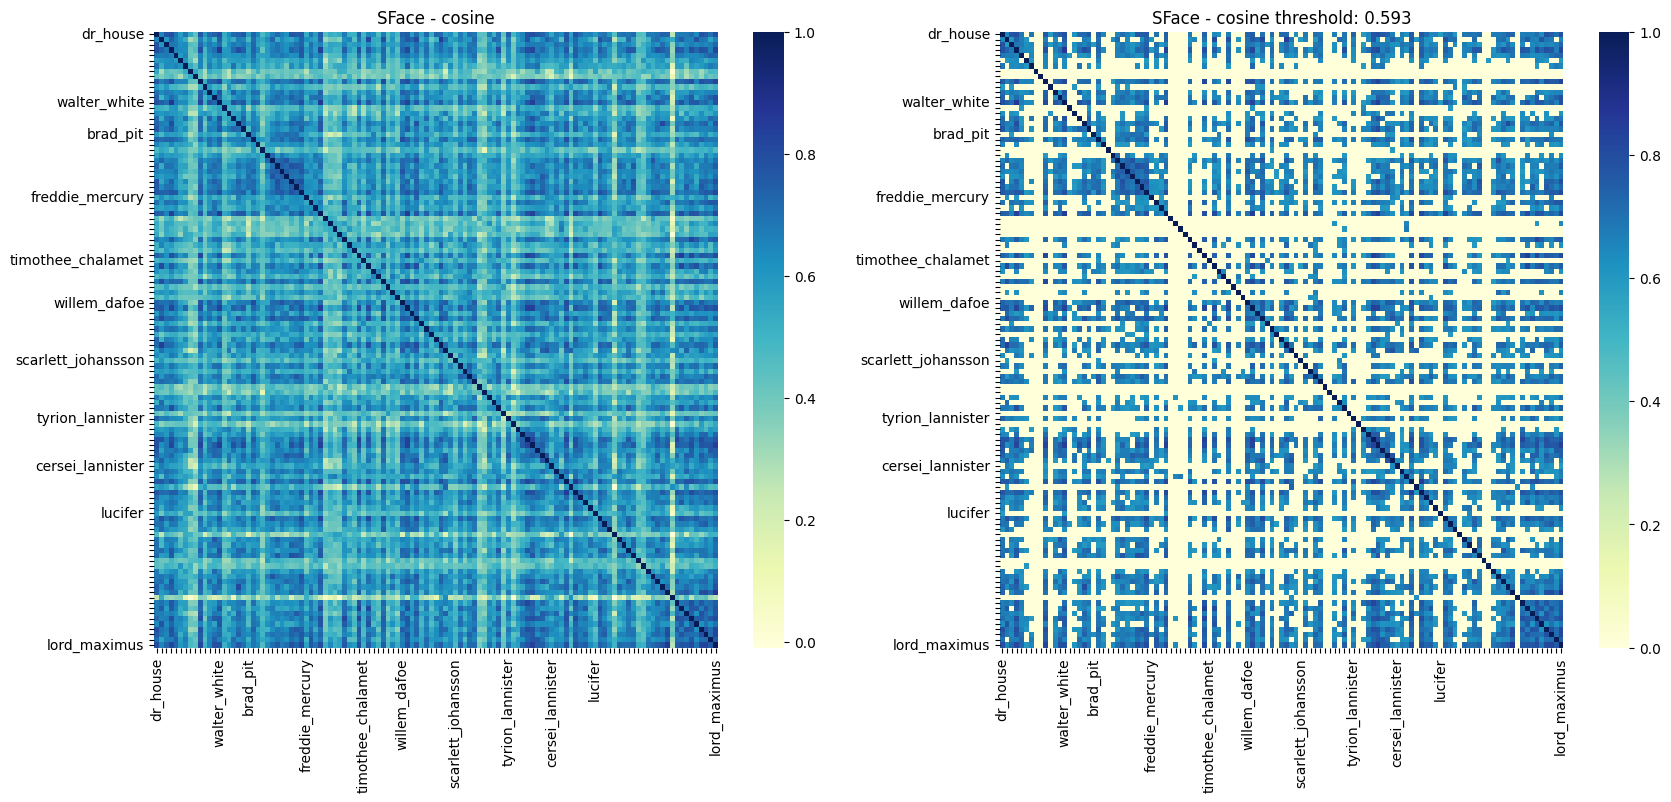

(117, 117)


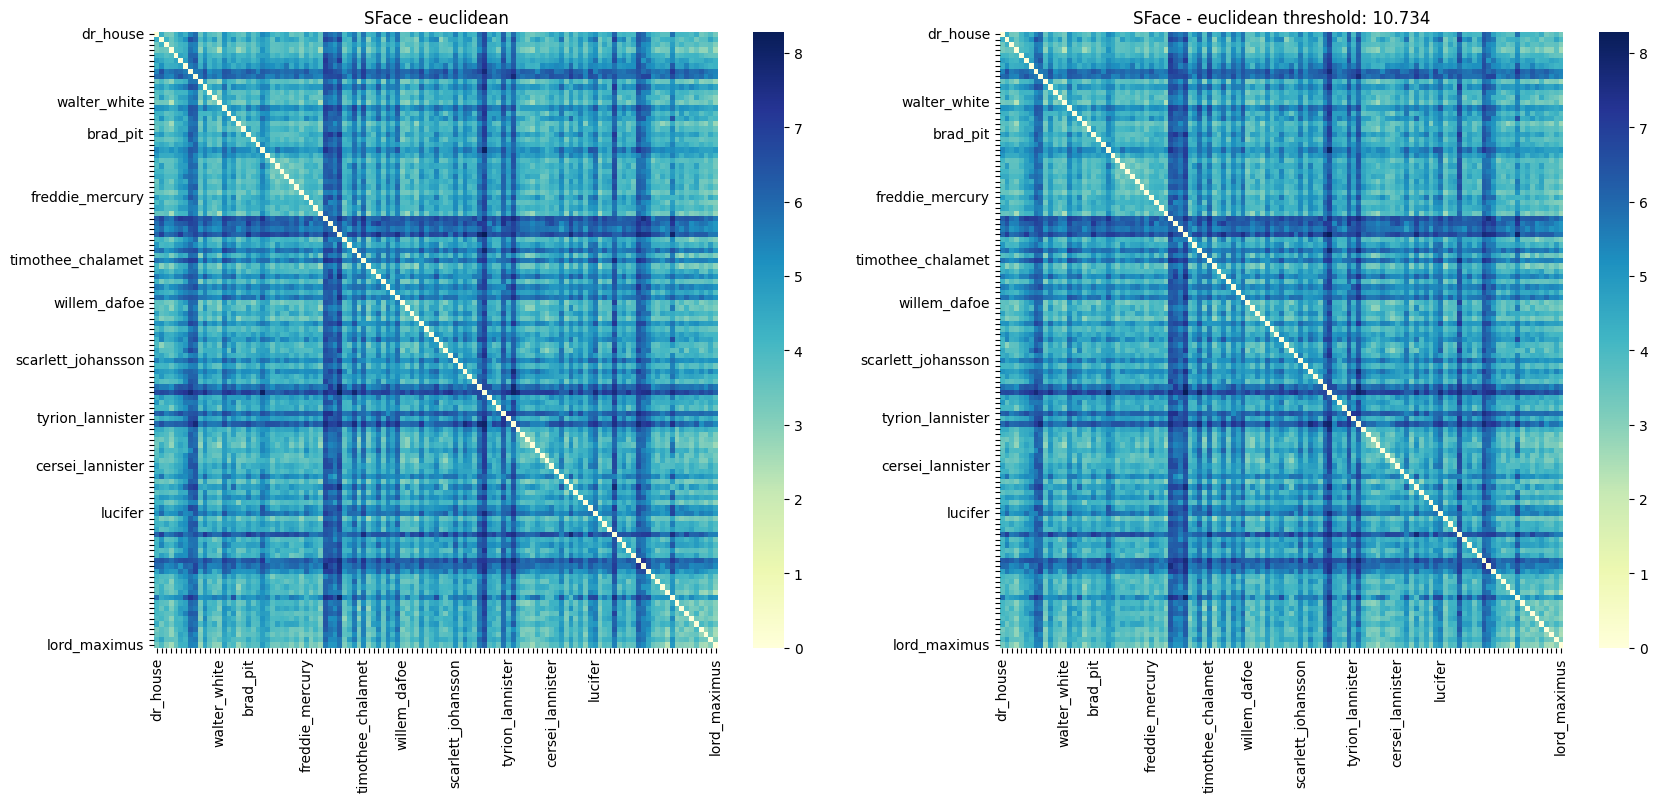

buffalo_s
(229, 512)
(229, 229)


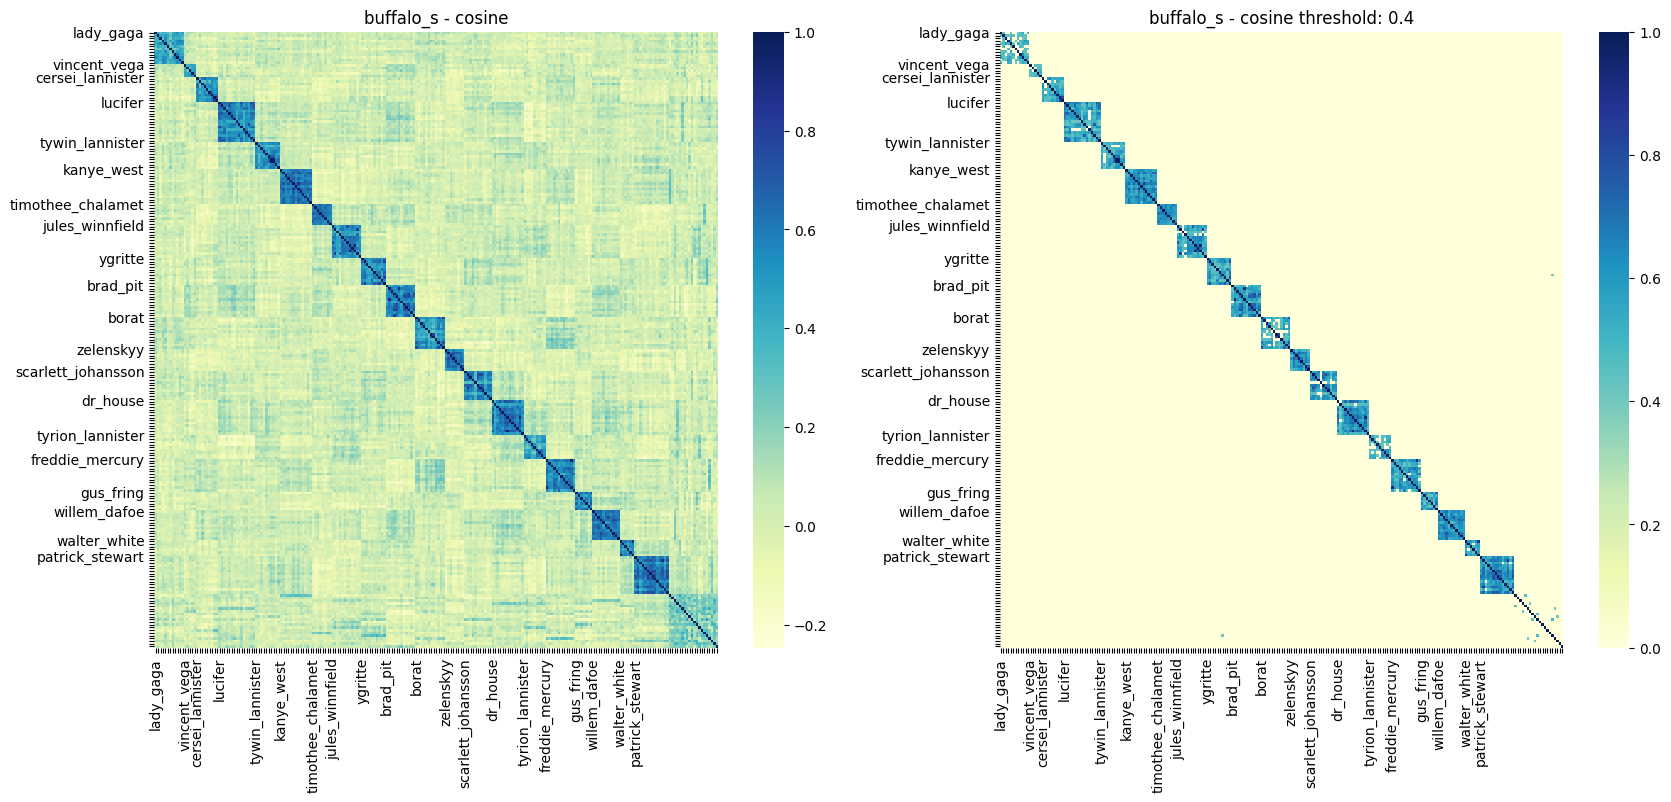

(229, 229)


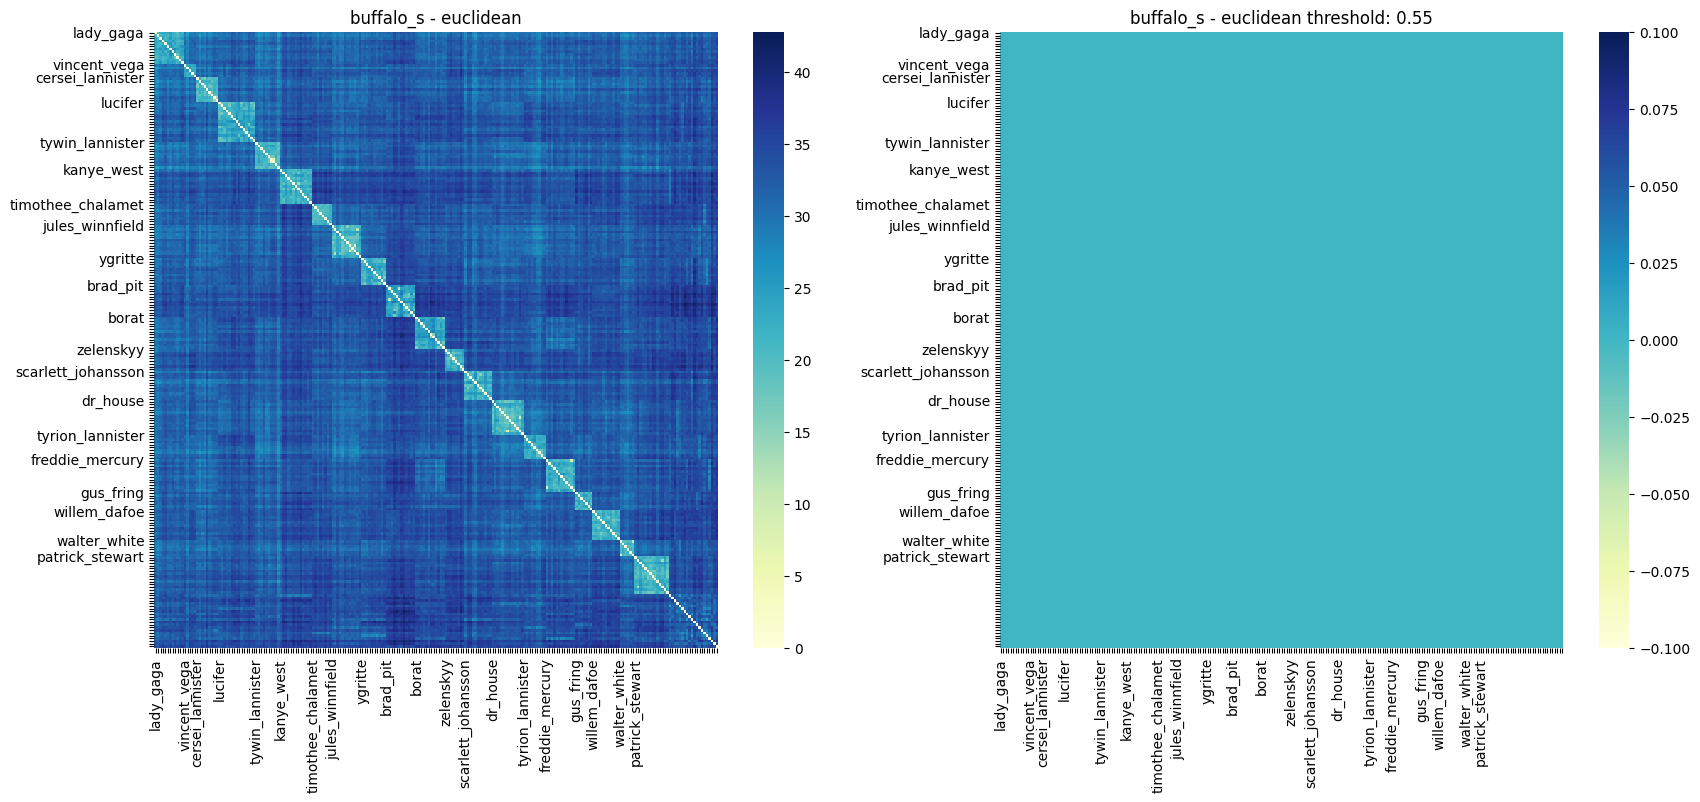

buffalo_sc
(229, 512)
(229, 229)


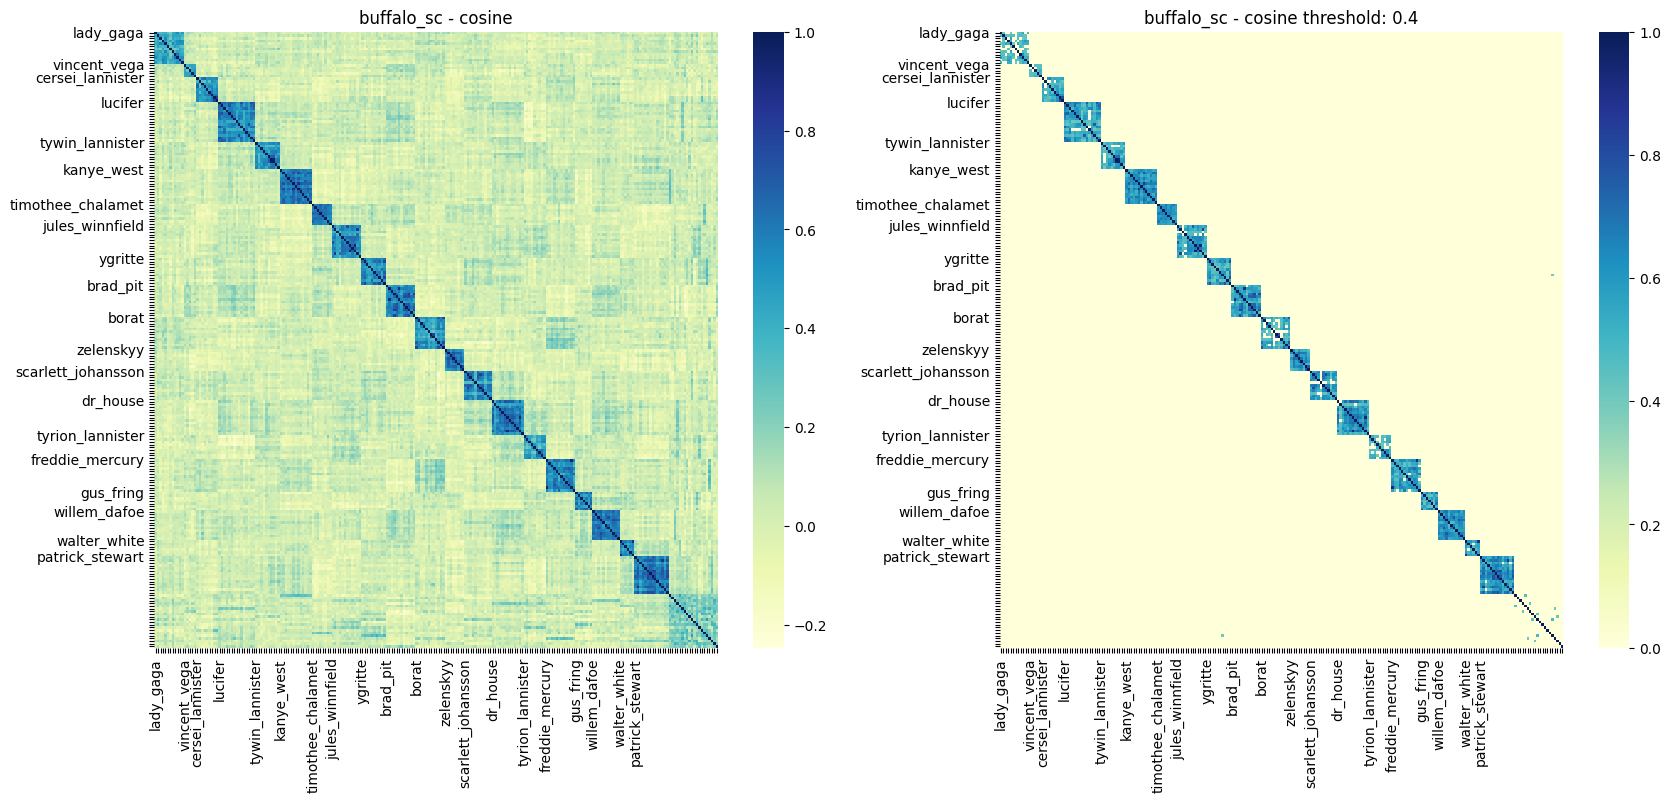

(229, 229)


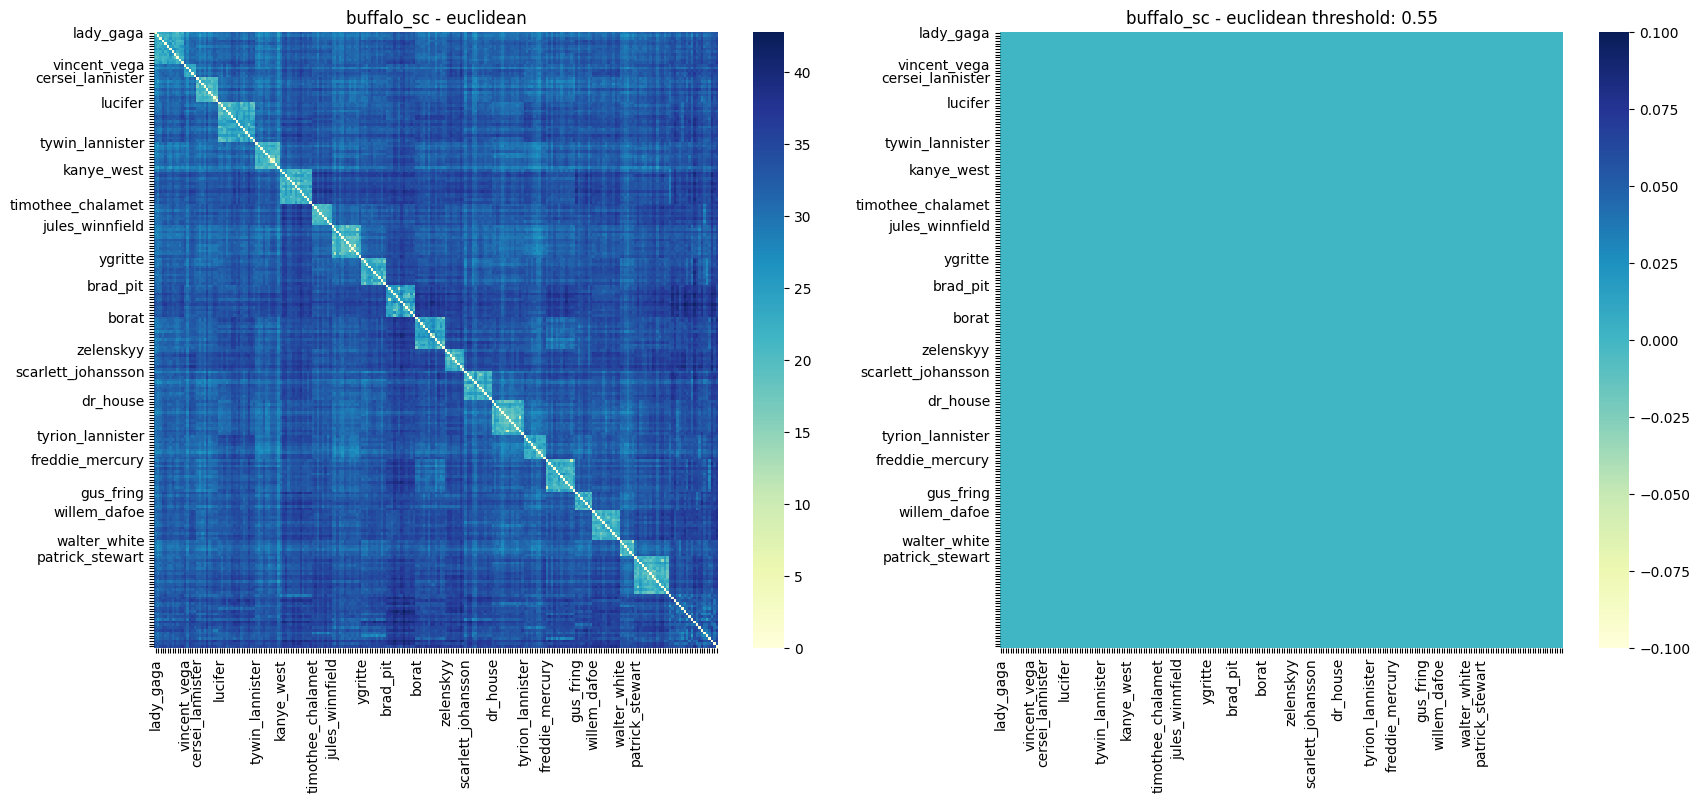

buffalo_m
(229, 512)
(229, 229)


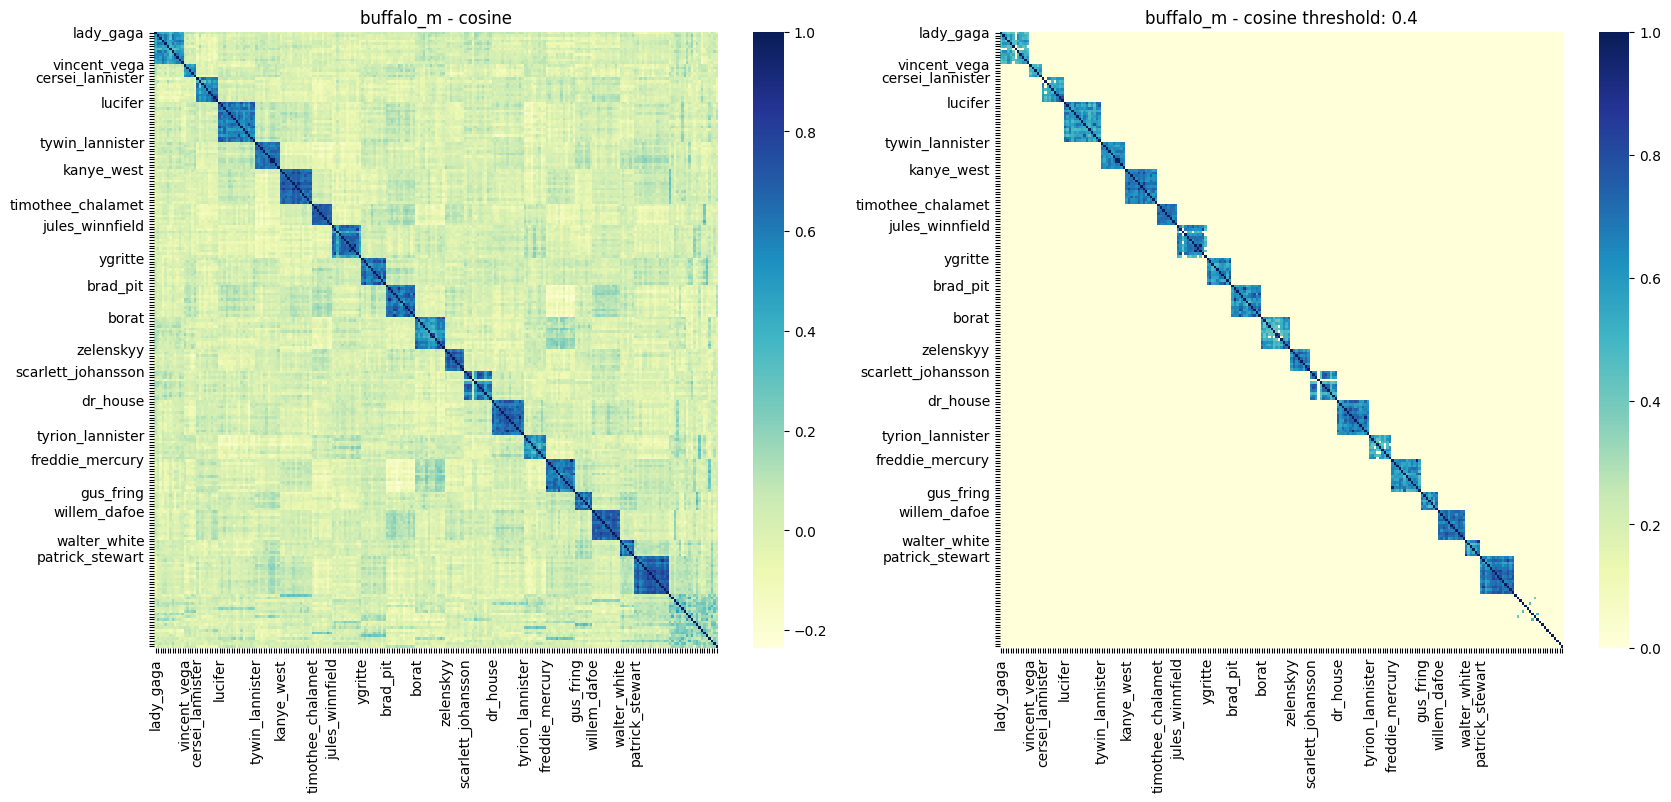

(229, 229)


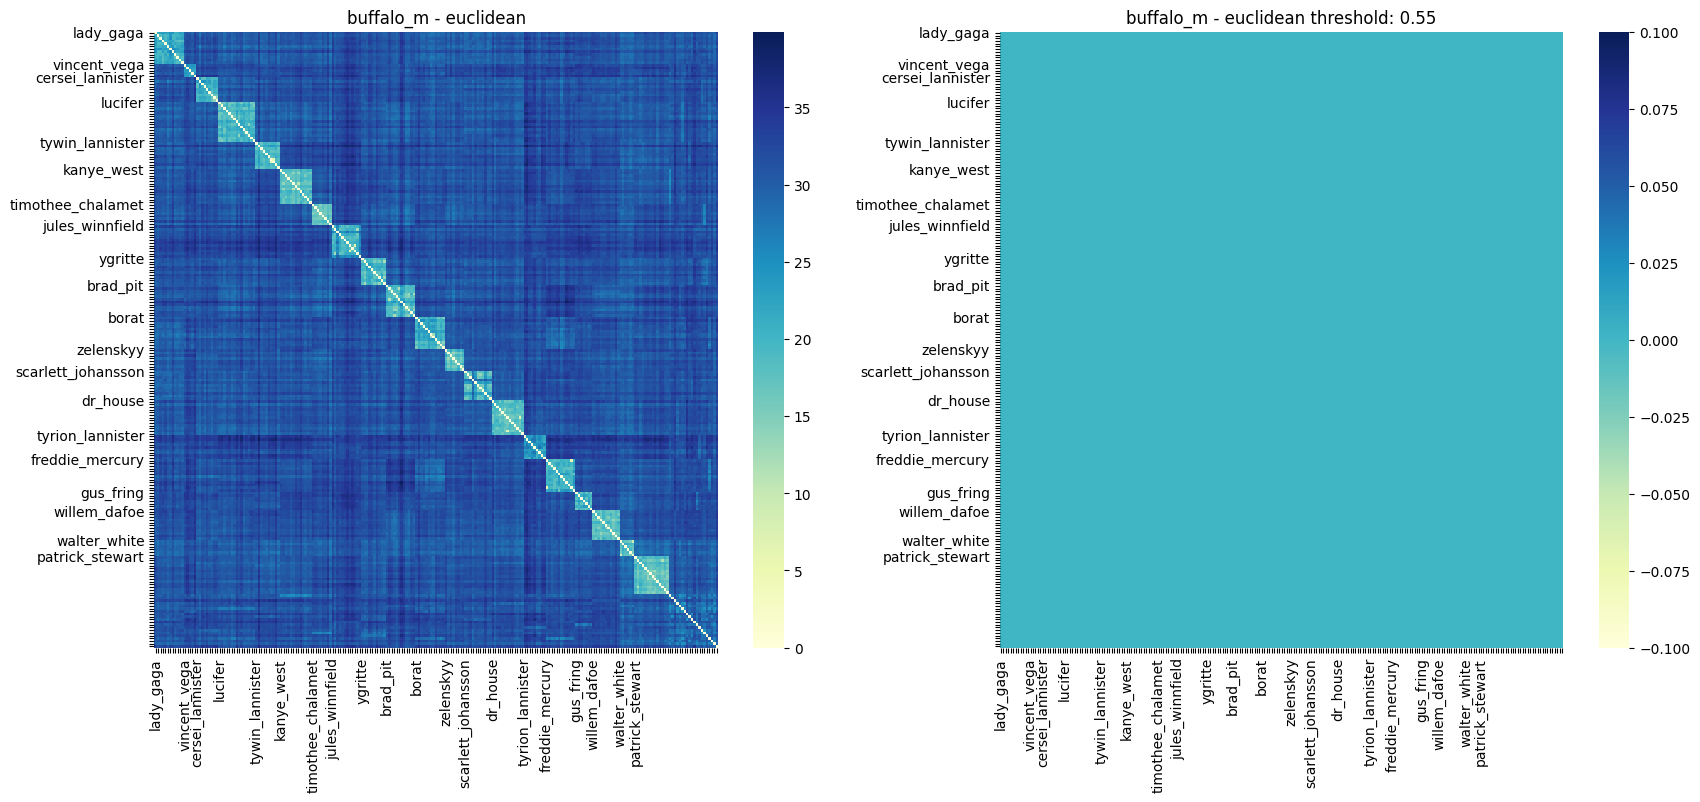

buffalo_l
(229, 512)
(229, 229)


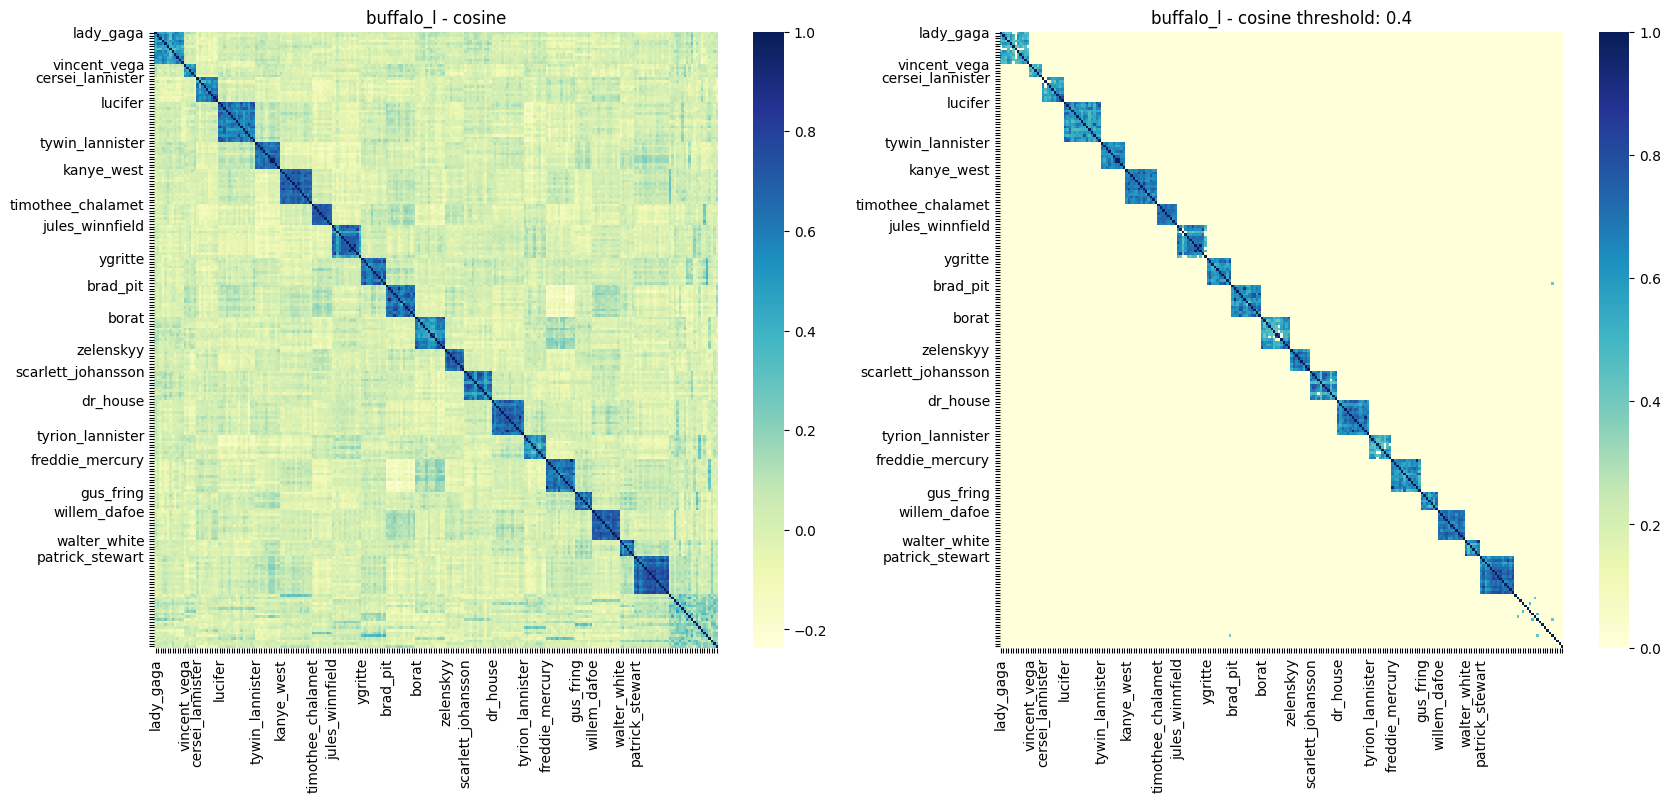

(229, 229)


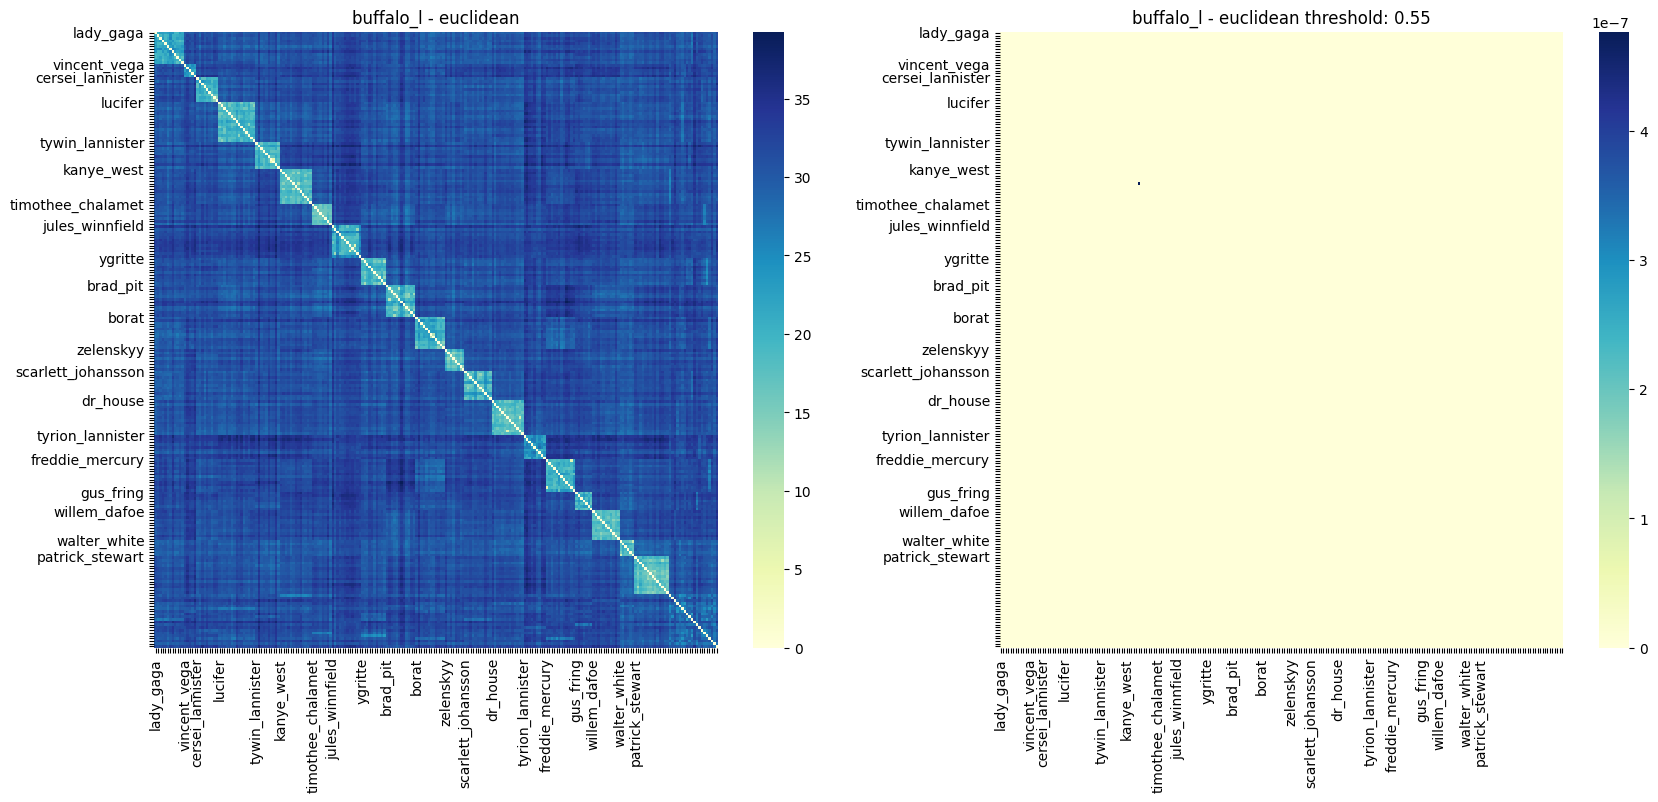

antelopev2
(229, 512)
(229, 229)


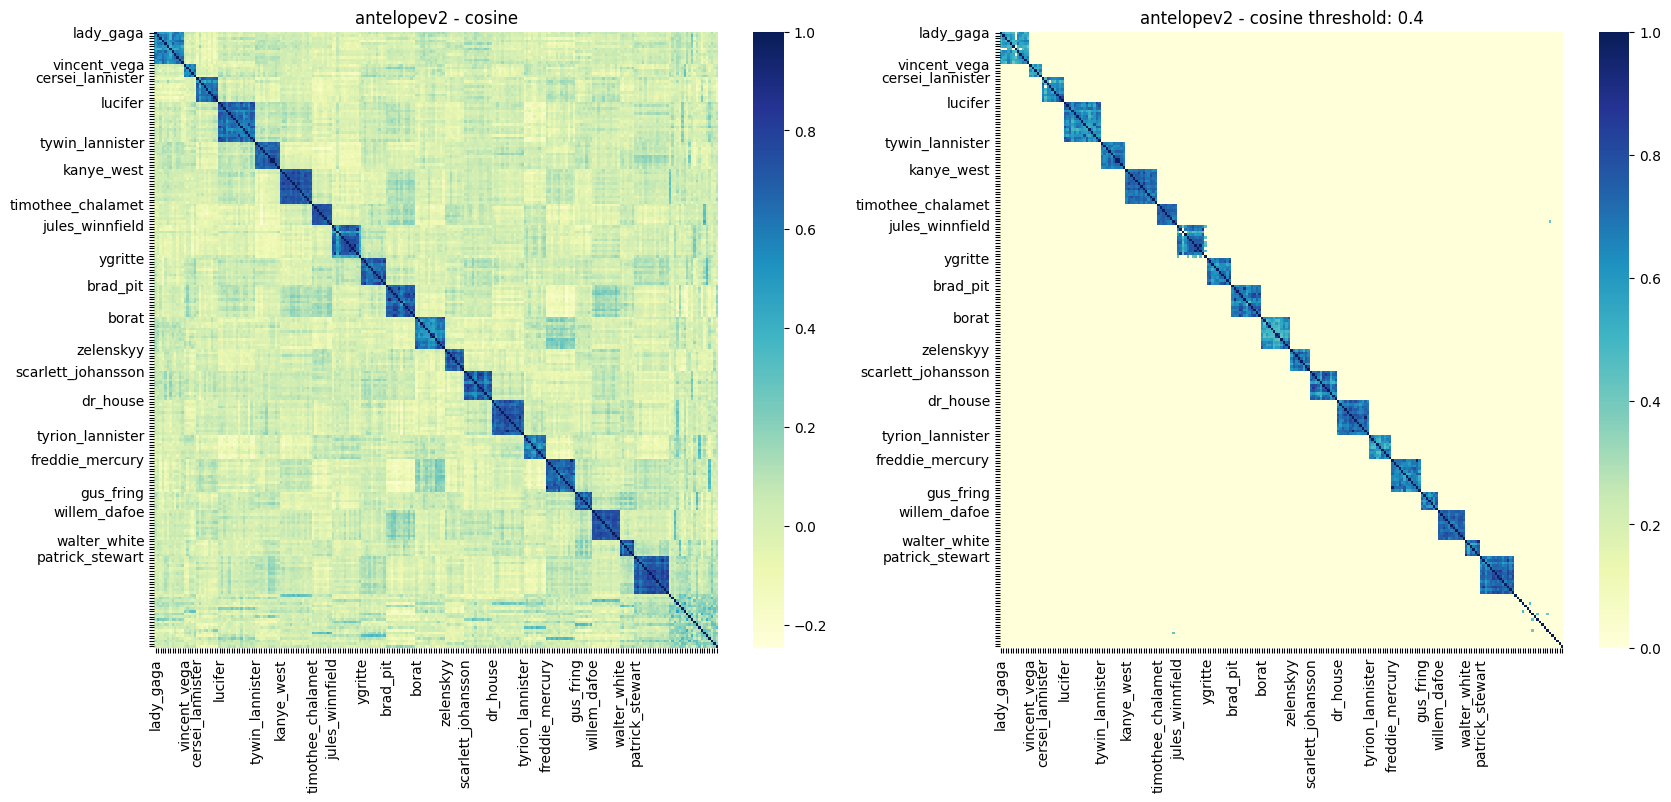

(229, 229)


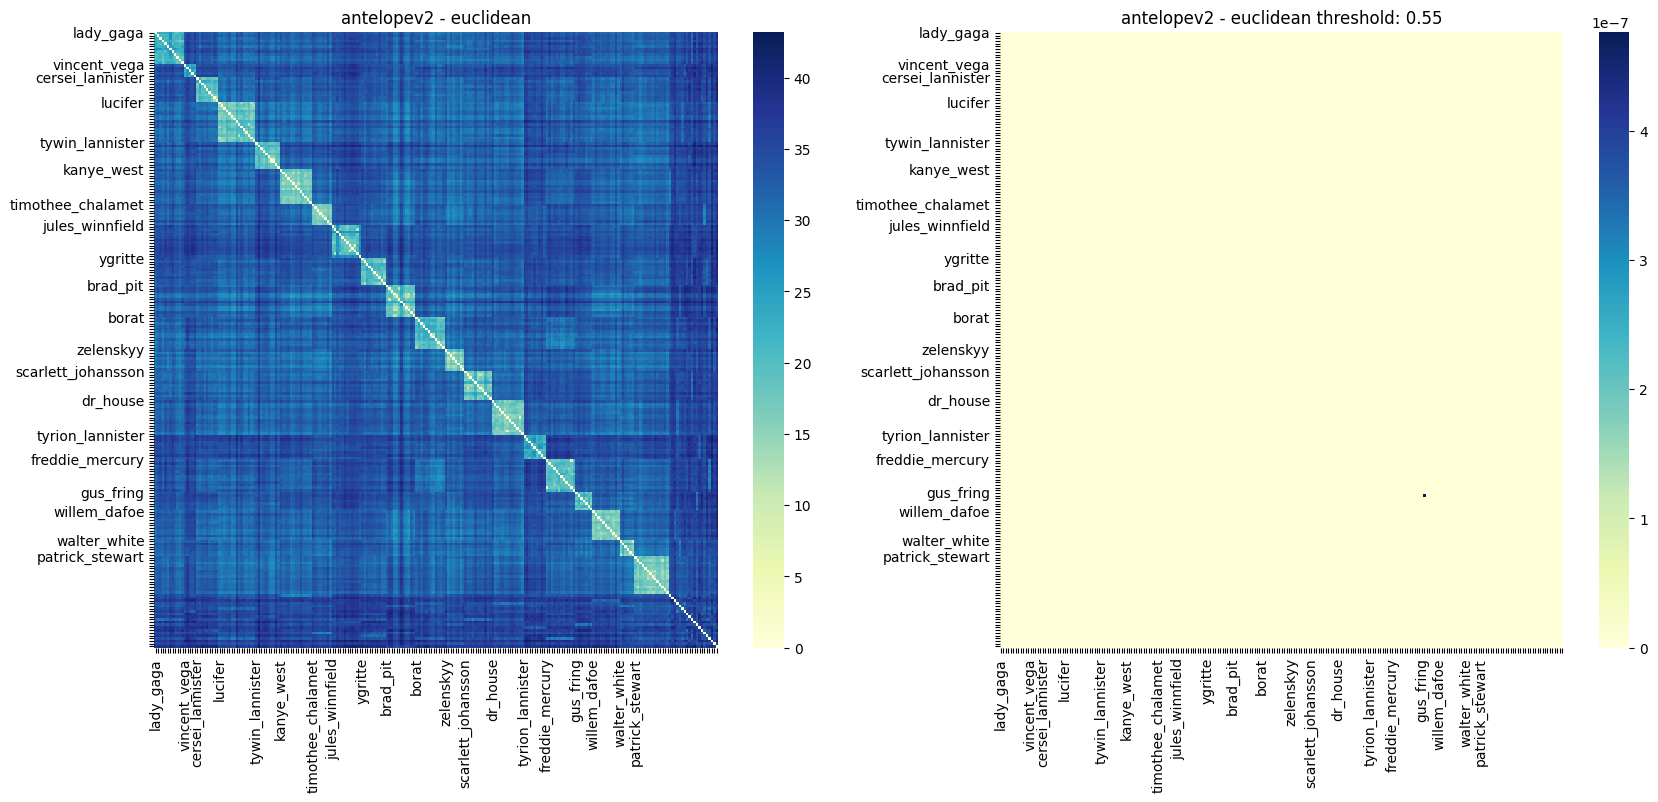

In [4]:
from deepface.commons.distance import findThreshold

# import cosine metric and euclidian metric from sklearn 
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances


for model_name, model_df in model2df.items():  
    print(model_name)
    X = np.array(model_df["embeddings"].values.tolist())
    print(X.shape)
    metric2distances = {}
    for metric_name, metric_fun in zip(["cosine", "euclidean"], [cosine_similarity, euclidean_distances]):
        distances = model_df["embeddings"].apply(lambda x: metric_fun(X, x.reshape(1, -1)))
        d = np.array(distances.values.tolist()).squeeze(-1)
        metric2distances[metric_name] = d
    
    labels = []
    for l in model_df["labels"]:
        if l not in labels:
            labels.append(l)
        else:
            labels.append("")
    
    # display heatmap for each metric
    for metric_name, d in metric2distances.items():
        fig, axs = plt.subplots(1, 2, figsize=(20, 8))
        sns.heatmap(
            d,
            xticklabels=labels,
            yticklabels=labels,
            cmap="YlGnBu",
            ax=axs[0]
        )
        axs[0].set_title(f"{model_name} - {metric_name}")

        thresh = findThreshold(model_name, metric_name)
        if metric_name == "cosine":
            d[d < thresh] = 0
        else:
            d[d > thresh] = 0

        print(d.shape)
        sns.heatmap(
            d,
            xticklabels=labels,
            yticklabels=labels,
            cmap="YlGnBu",
            ax=axs[1]
        )
        axs[1].set_title(f"{model_name} - {metric_name} threshold: {thresh}")
        plt.show()

# Map embeddings onto 2D plane

## t-SNE

In [5]:
from sklearn.manifold import TSNE

model2tsne = {}
for model, model_dict in embeddings.items():
    model_df = dict2df(model_dict)
    X = np.array(model_df["embeddings"].values.tolist())

    tsne = TSNE(n_components=2, random_state=0, perplexity=15, n_iter=2000, metric="cosine")
    embeddings_tsne = tsne.fit_transform(X)

    model2tsne[model] = embeddings_tsne

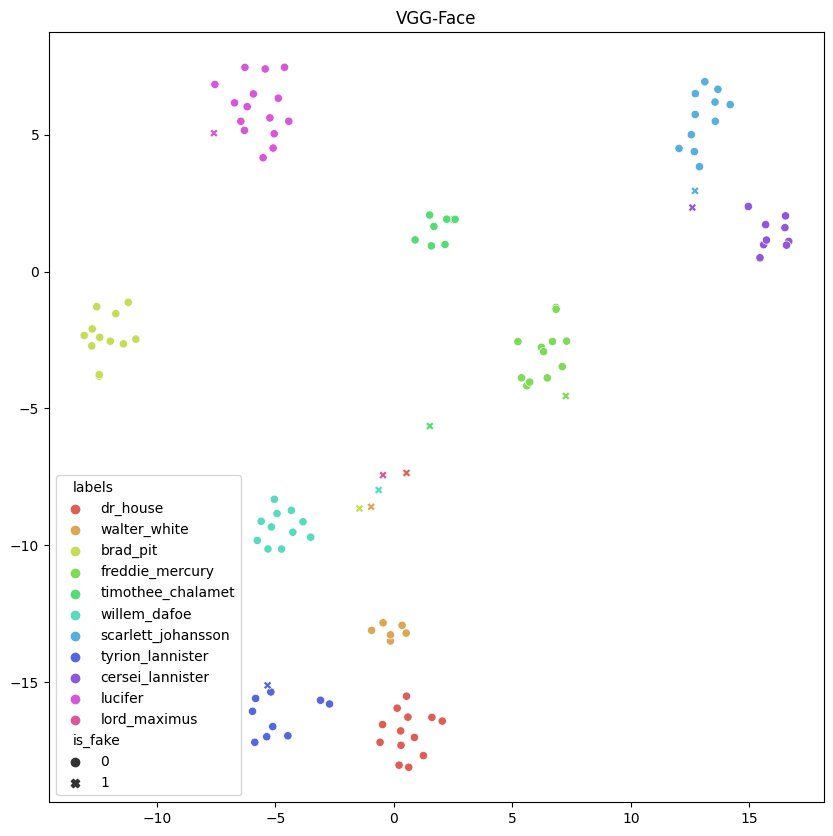

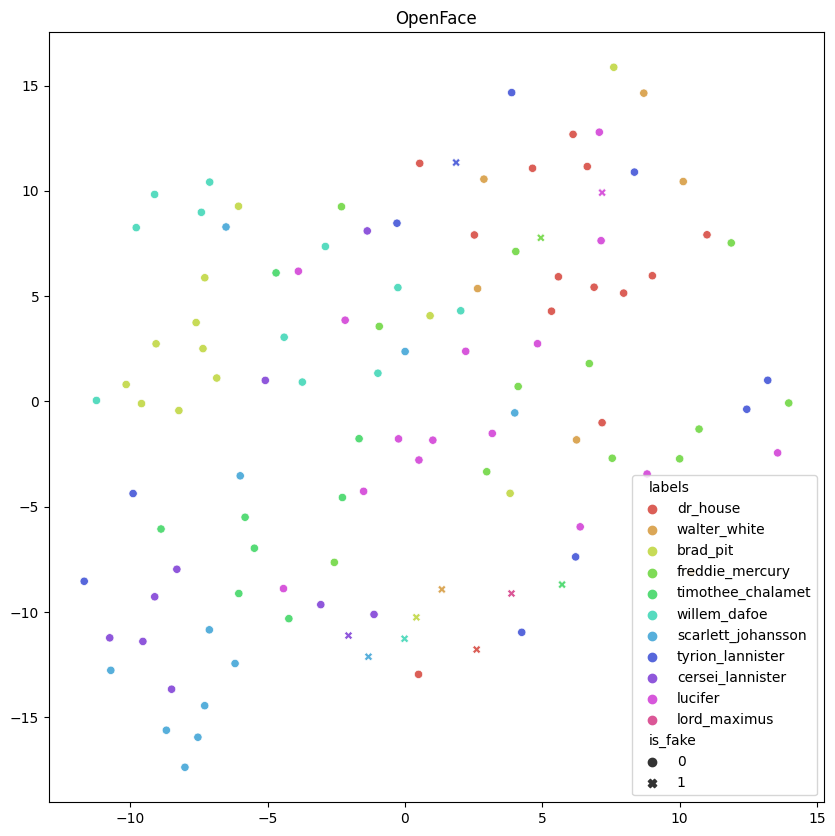

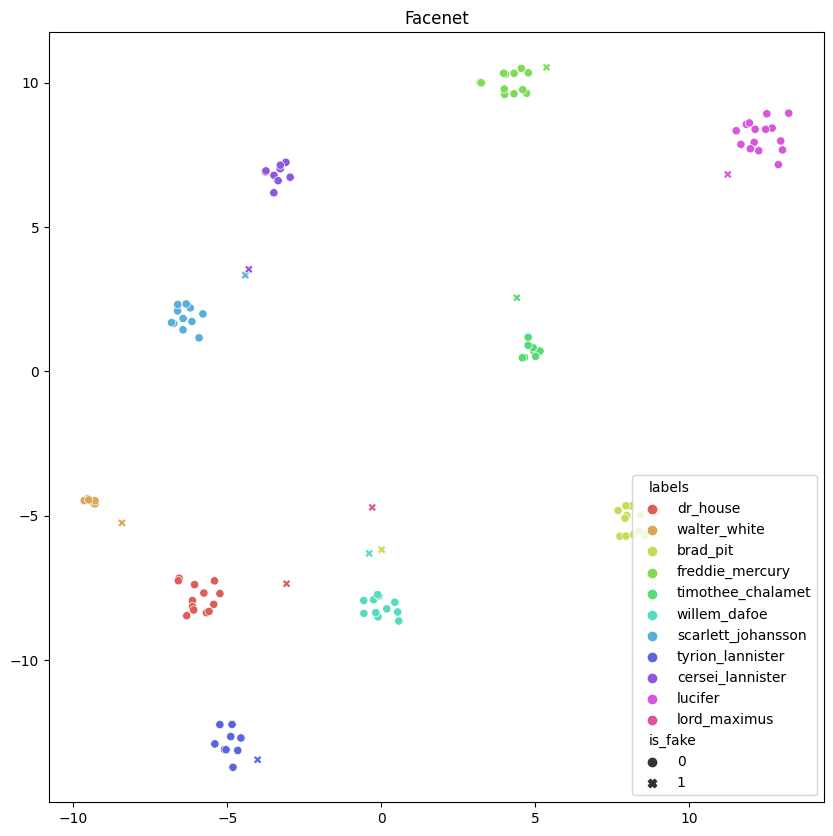

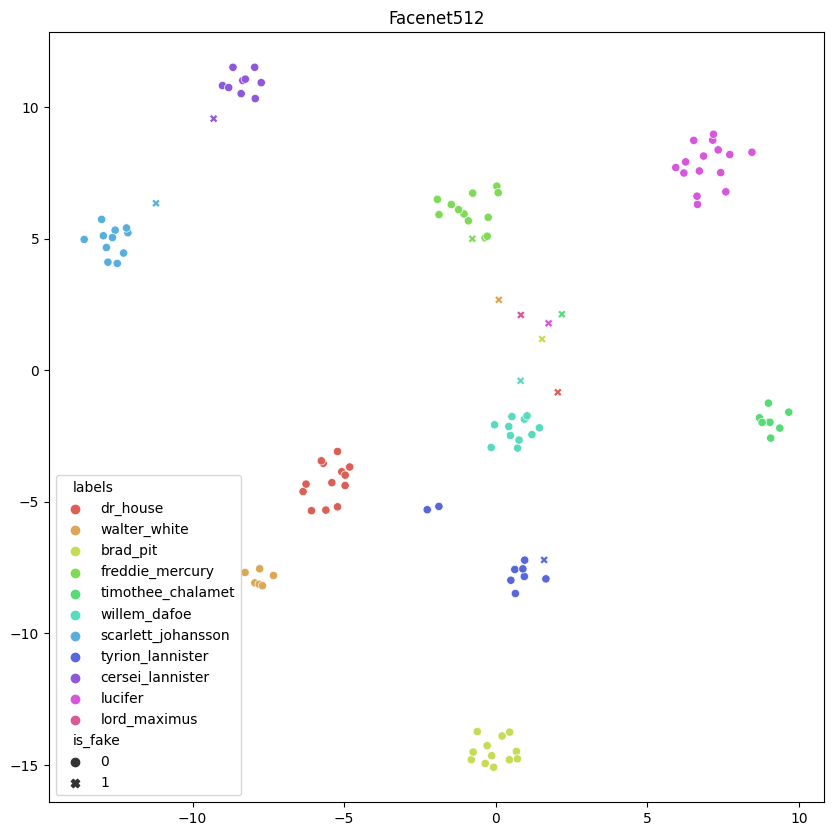

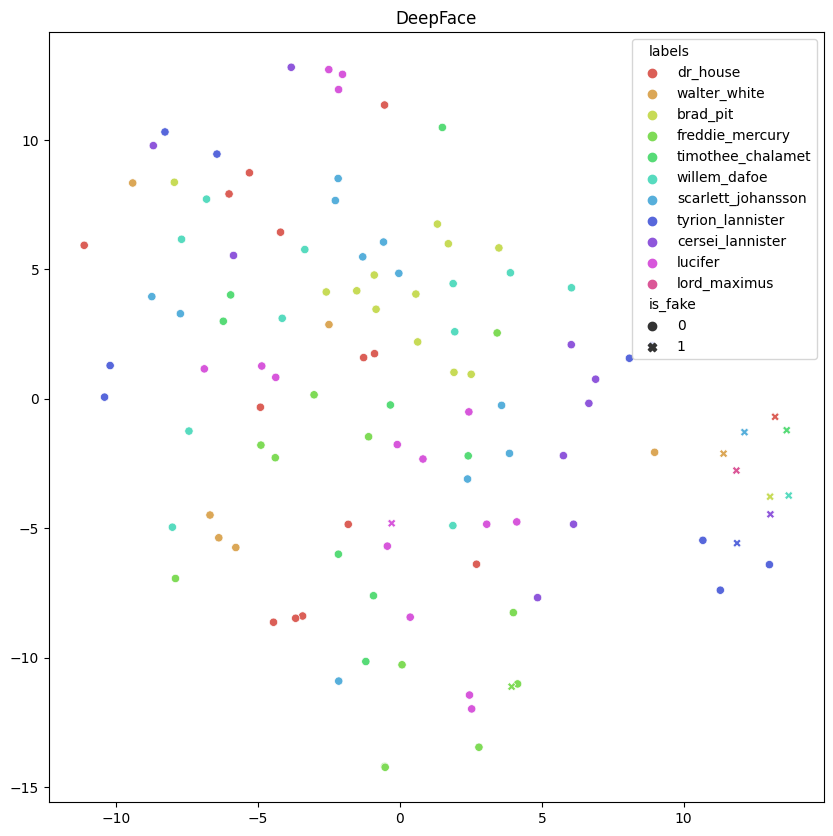

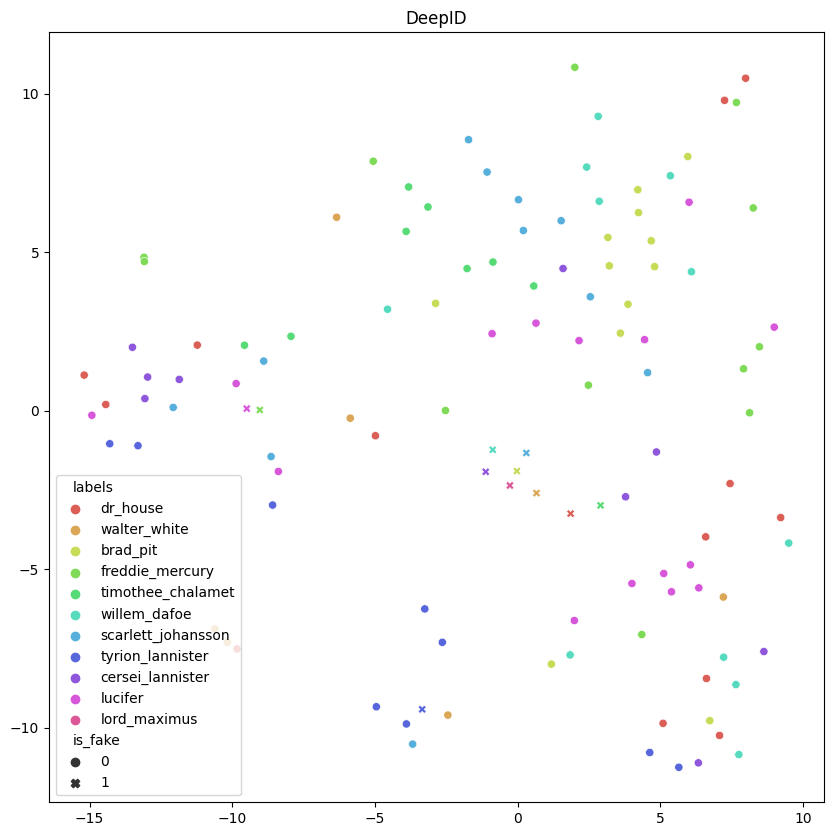

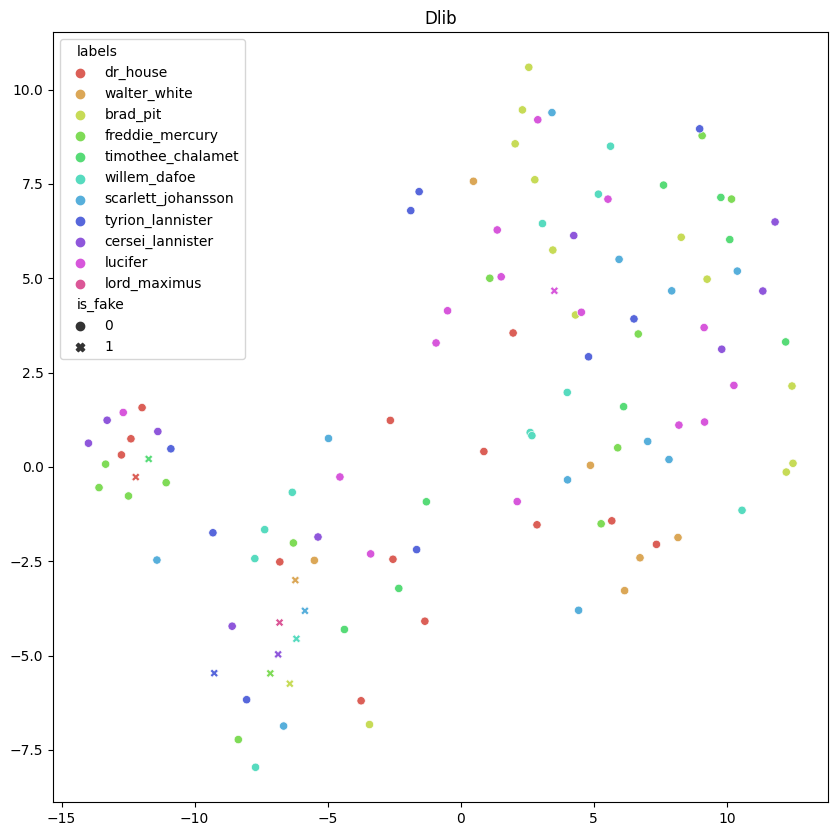

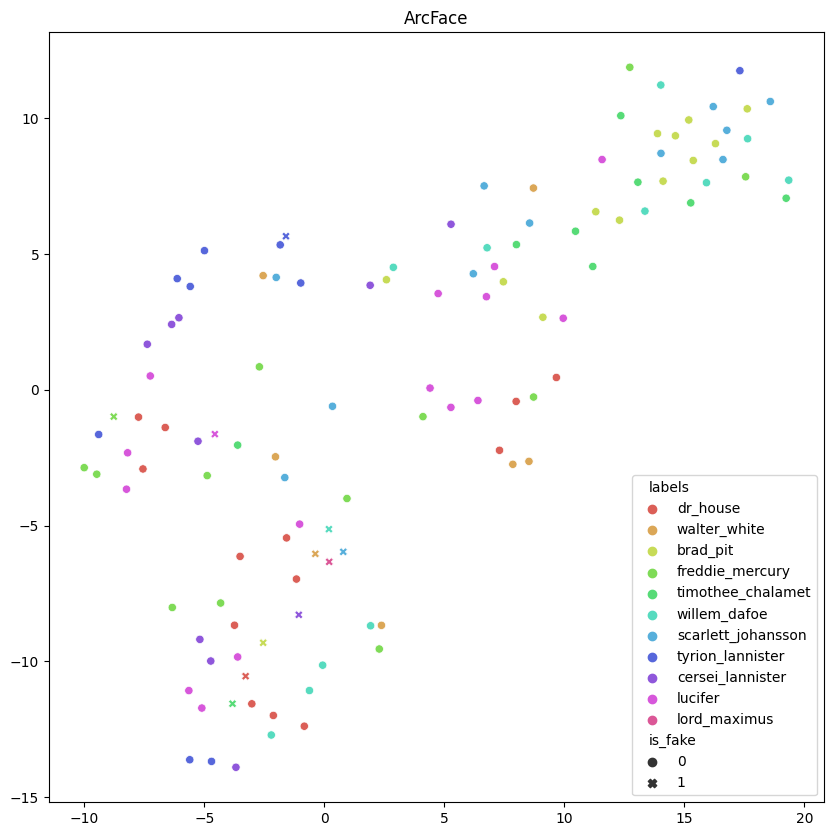

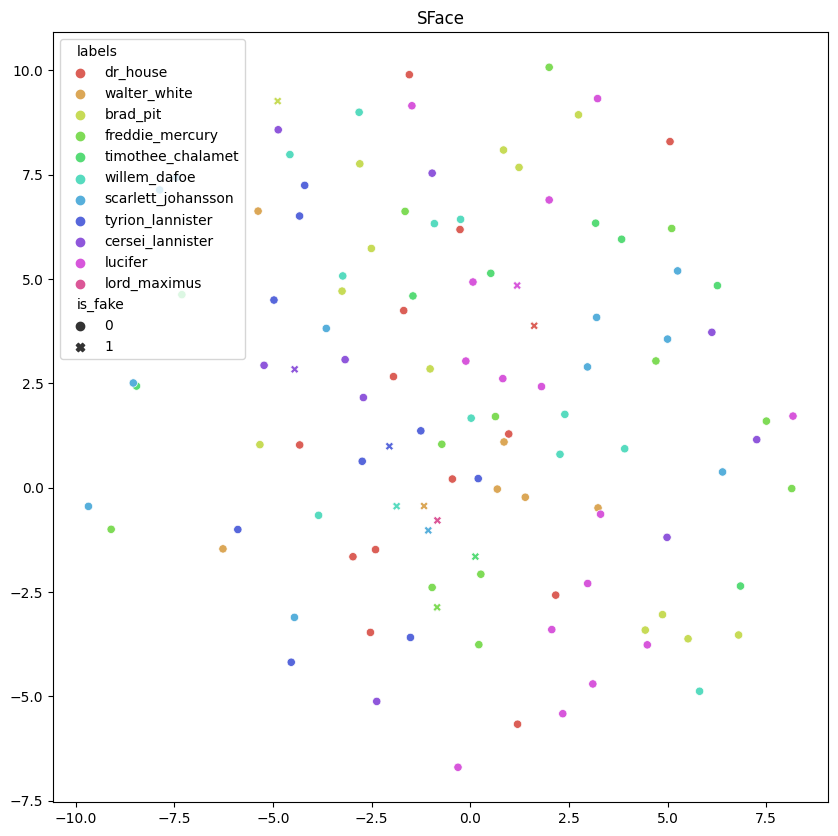

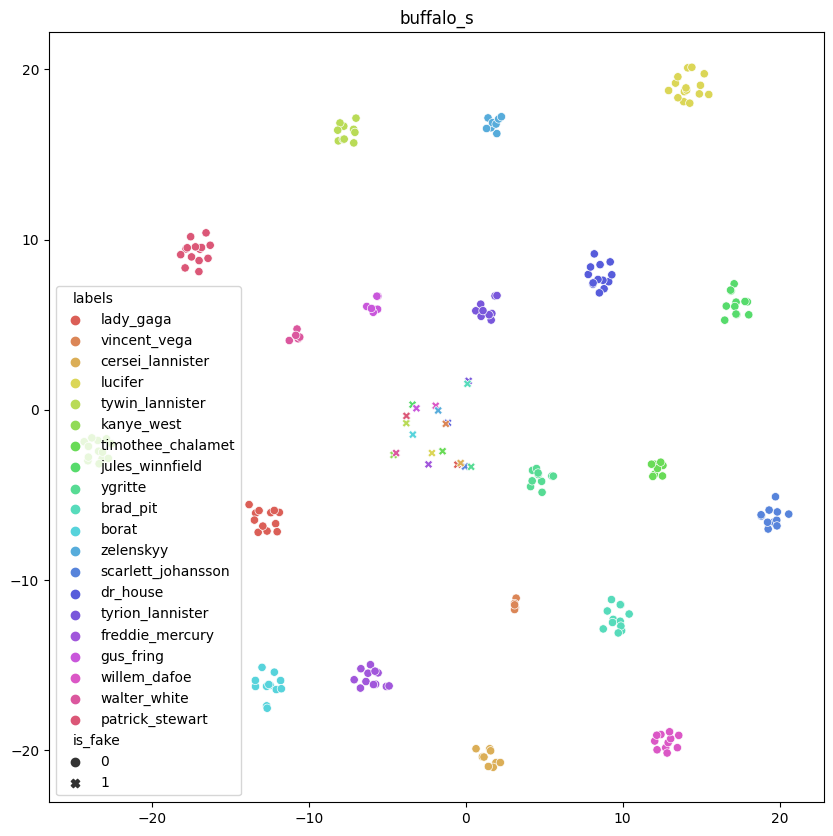

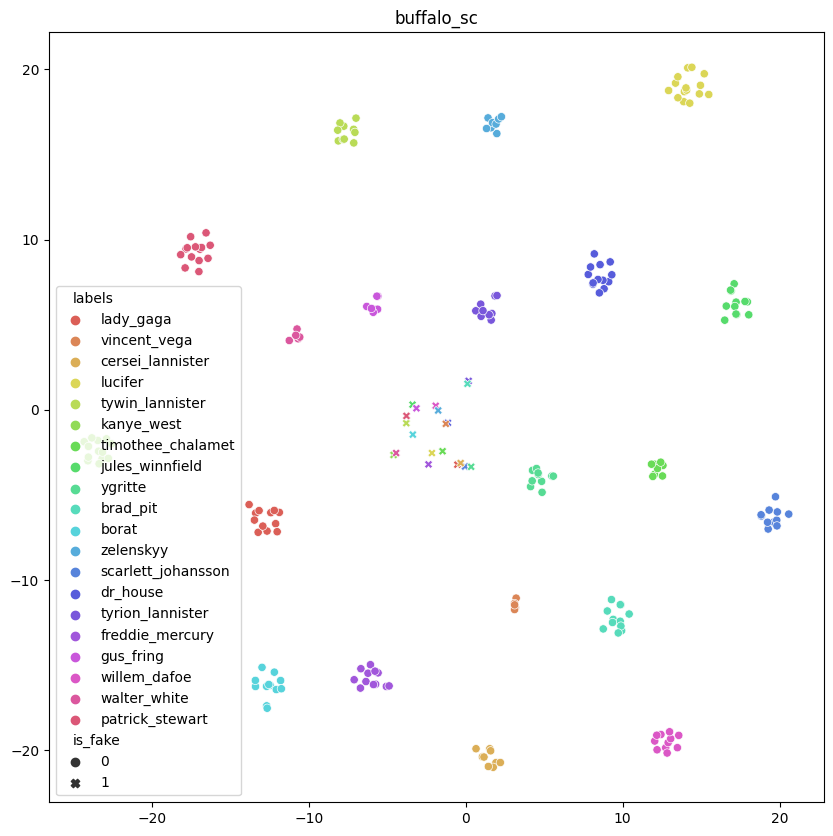

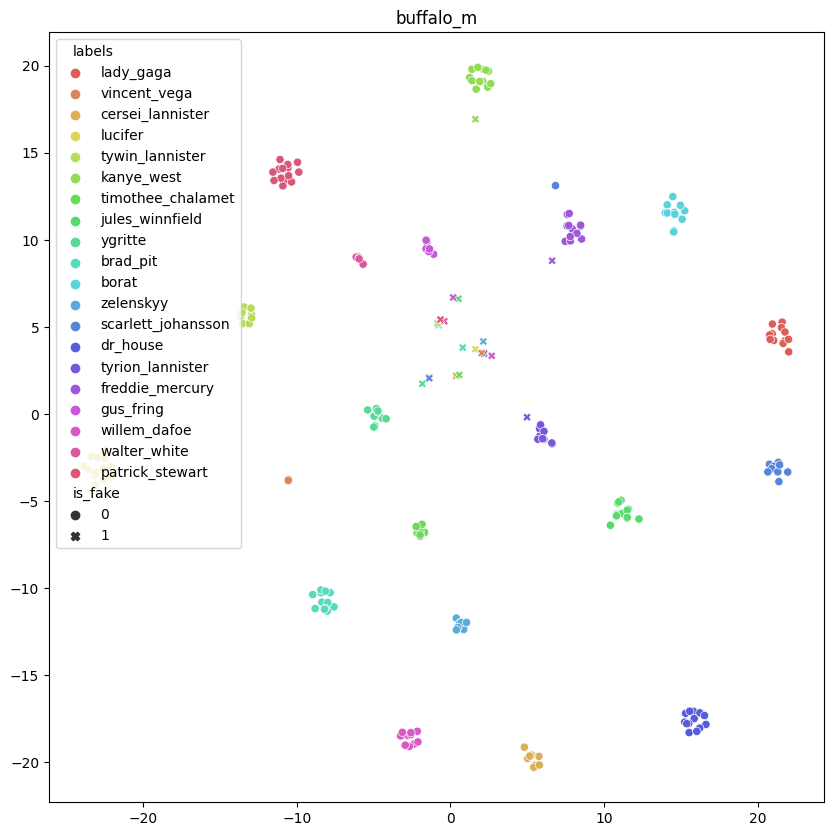

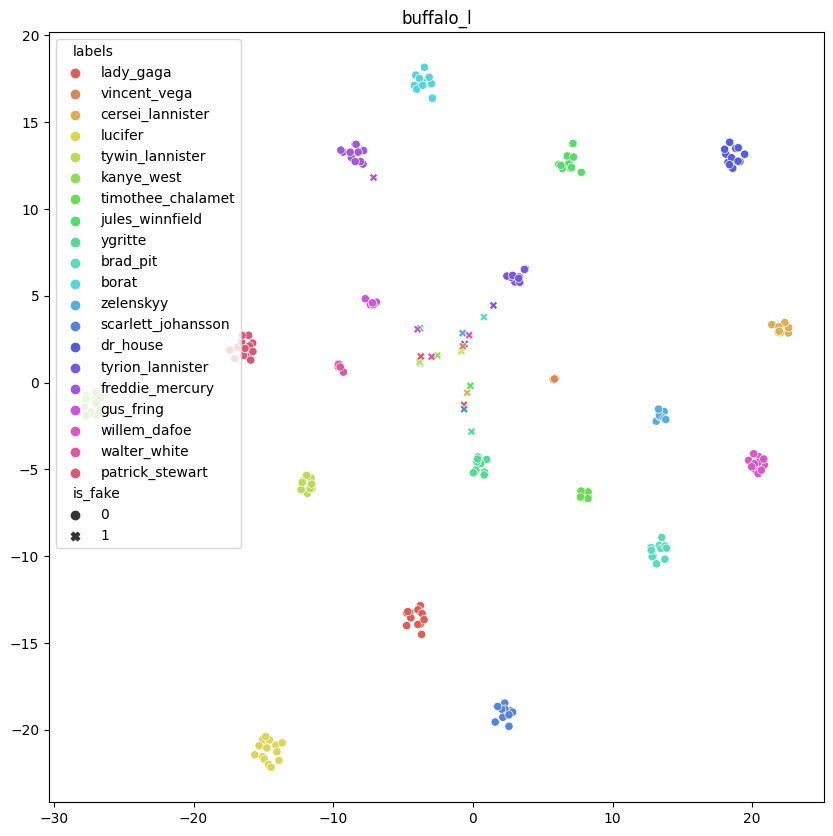

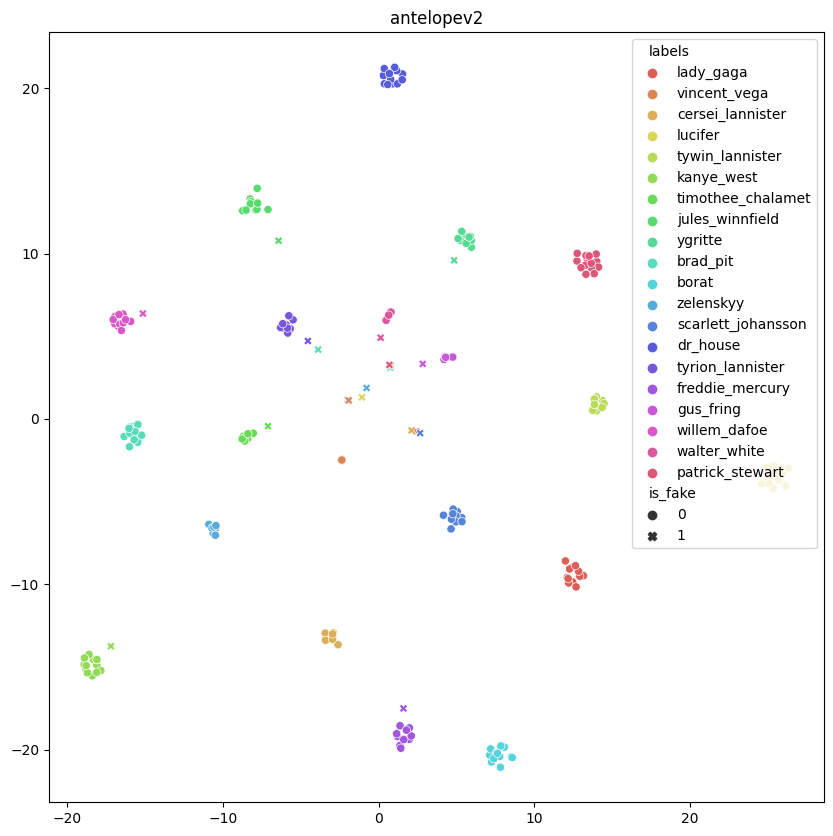

In [6]:
for model, tsne_mapping in model2tsne.items():
    plt.figure(figsize=(10, 10))
    sns.scatterplot(
        x=tsne_mapping[:,0], y=tsne_mapping[:,1],
        hue=model2df[model]["labels"],
        style=model2df[model]["is_fake"],
        palette=sns.color_palette("hls", len(model2df[model]["labels"].unique()))
    )
    plt.title(model)
    plt.show()

## UMAP

In [11]:
from umap import UMAP

model2umap= {}
for model, model_dict in embeddings.items():
    model_df = dict2df(model_dict)
    X = np.array(model_df["embeddings"].values.tolist())

    umap = UMAP(n_components=2, random_state=0, n_neighbors=5, min_dist=0.1, metric='cosine')
    embeddings_umap = umap.fit_transform(X)

    model2umap[model] = embeddings_umap
    

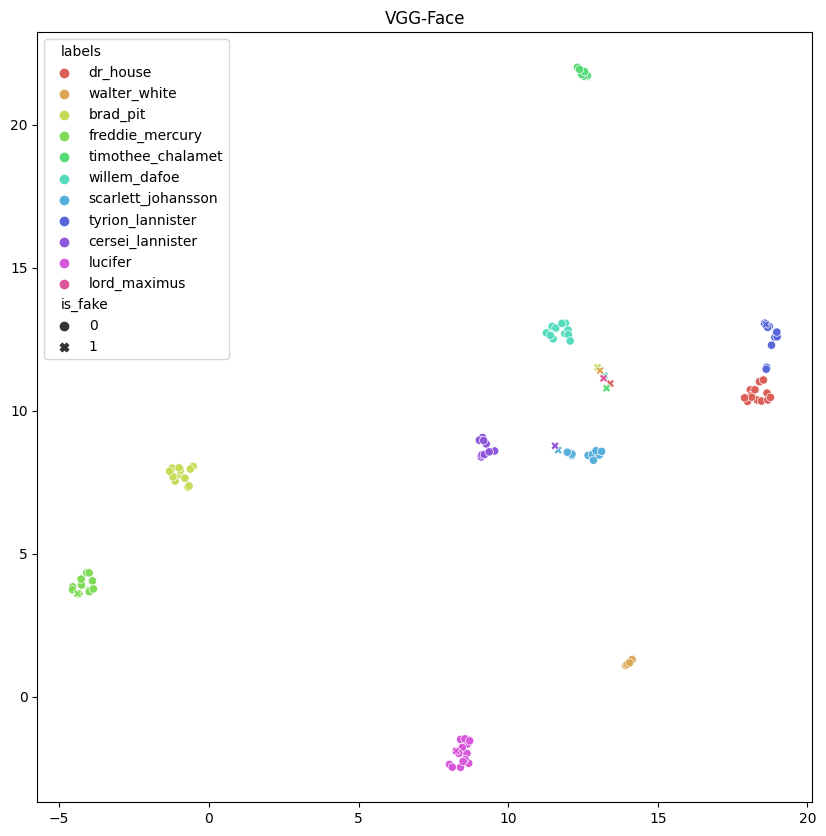

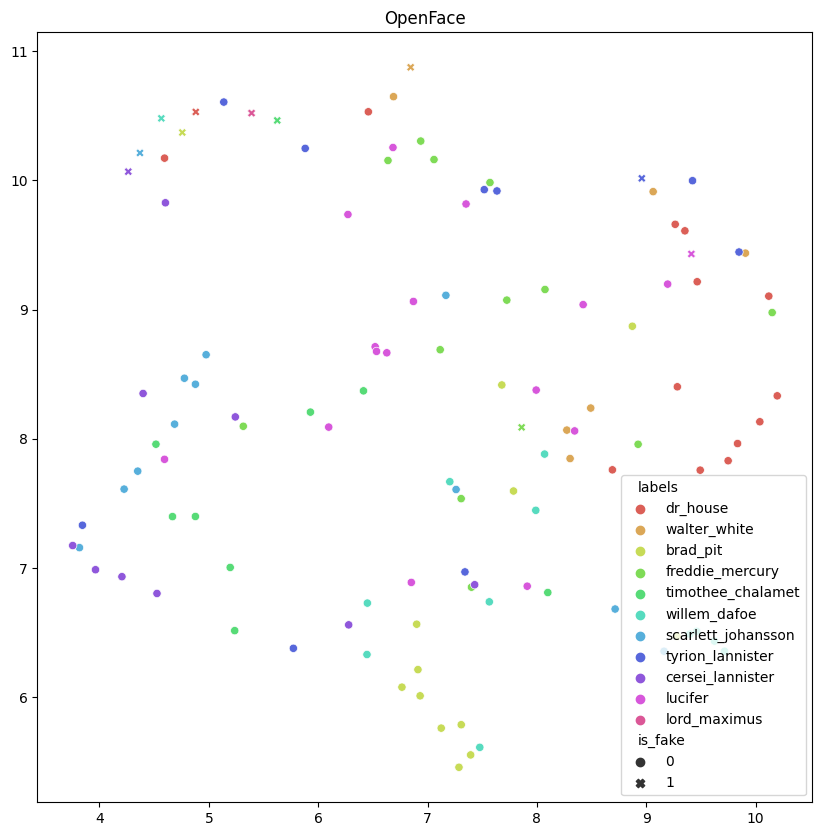

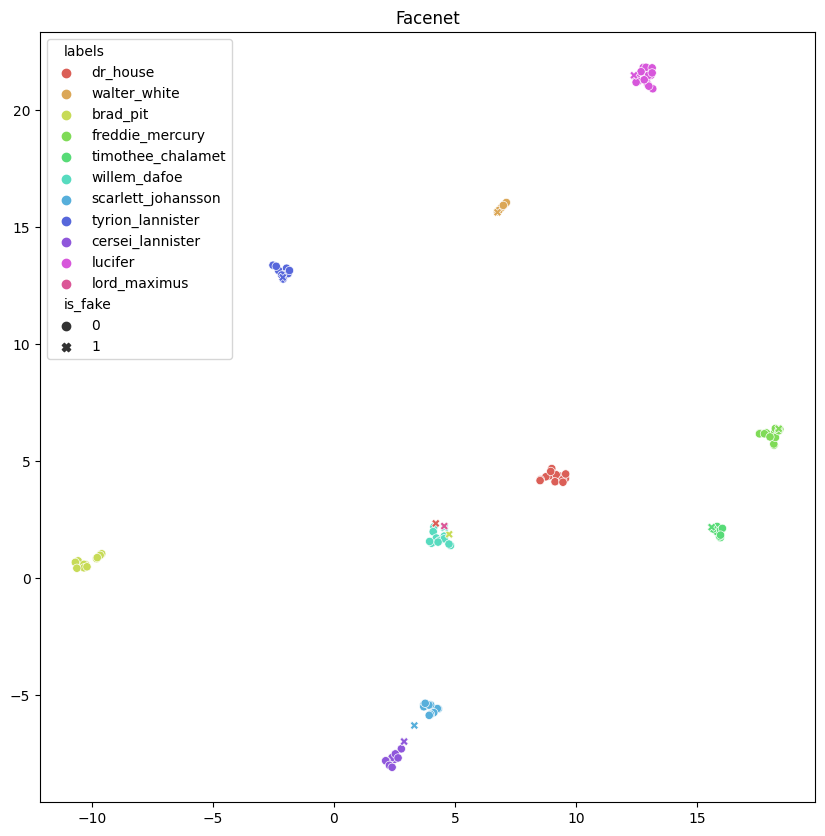

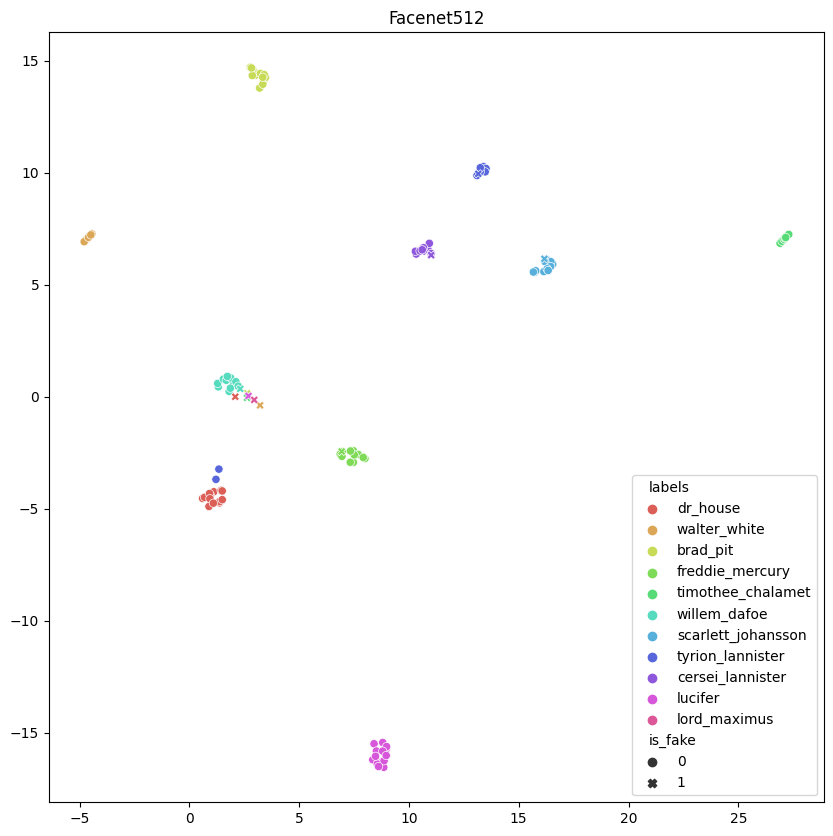

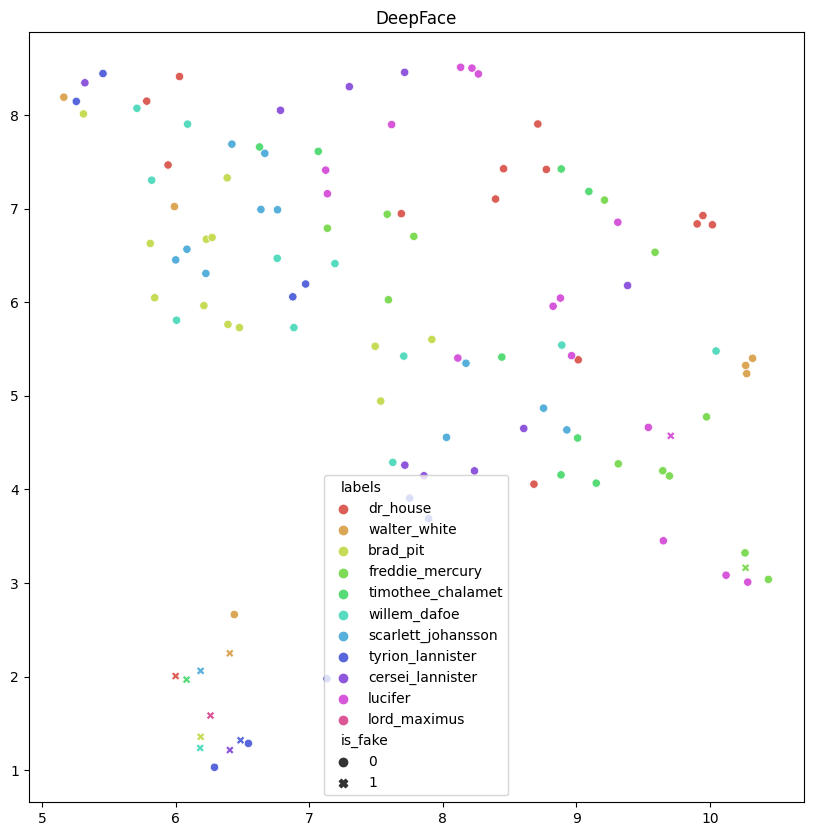

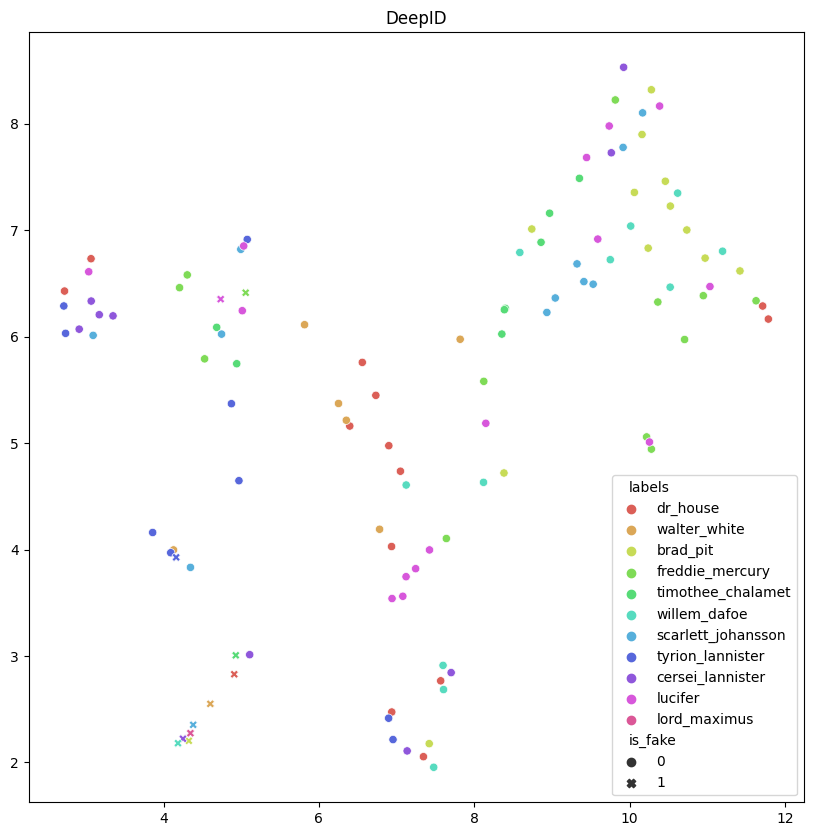

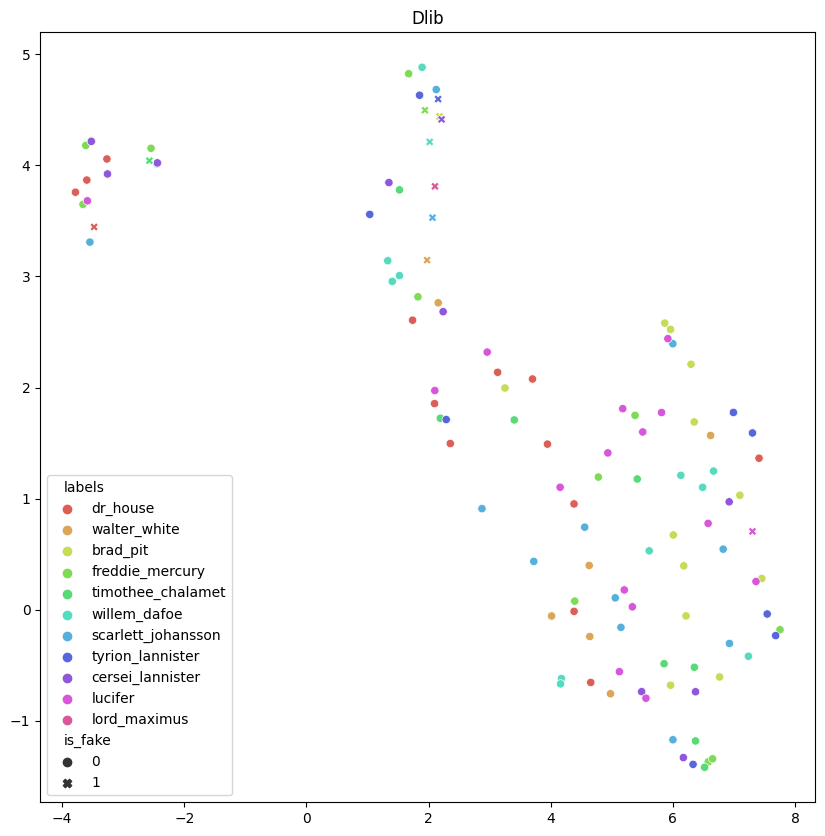

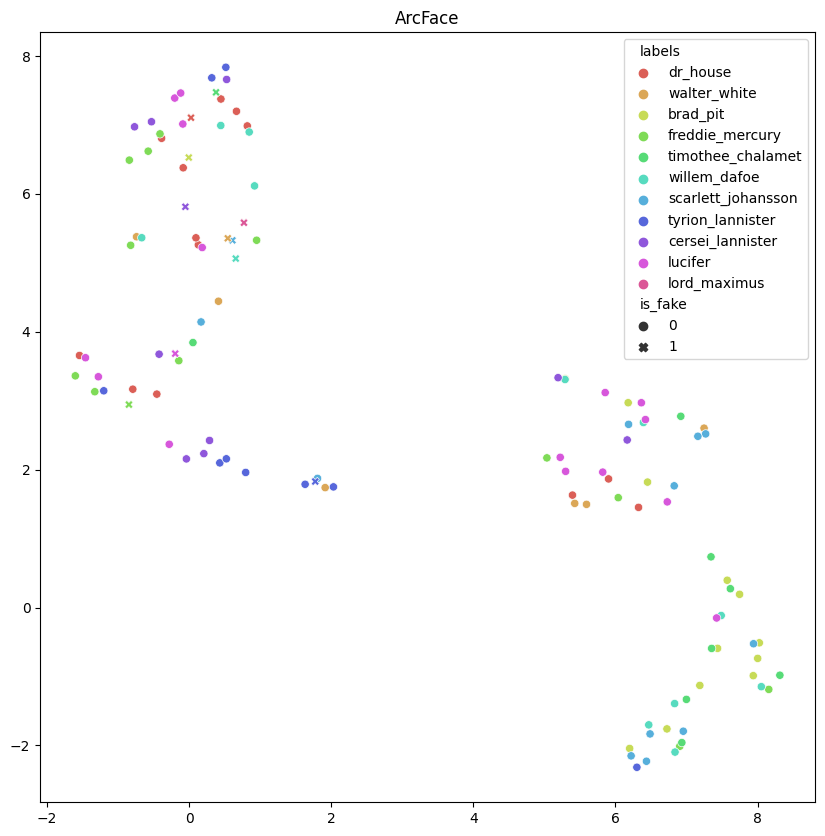

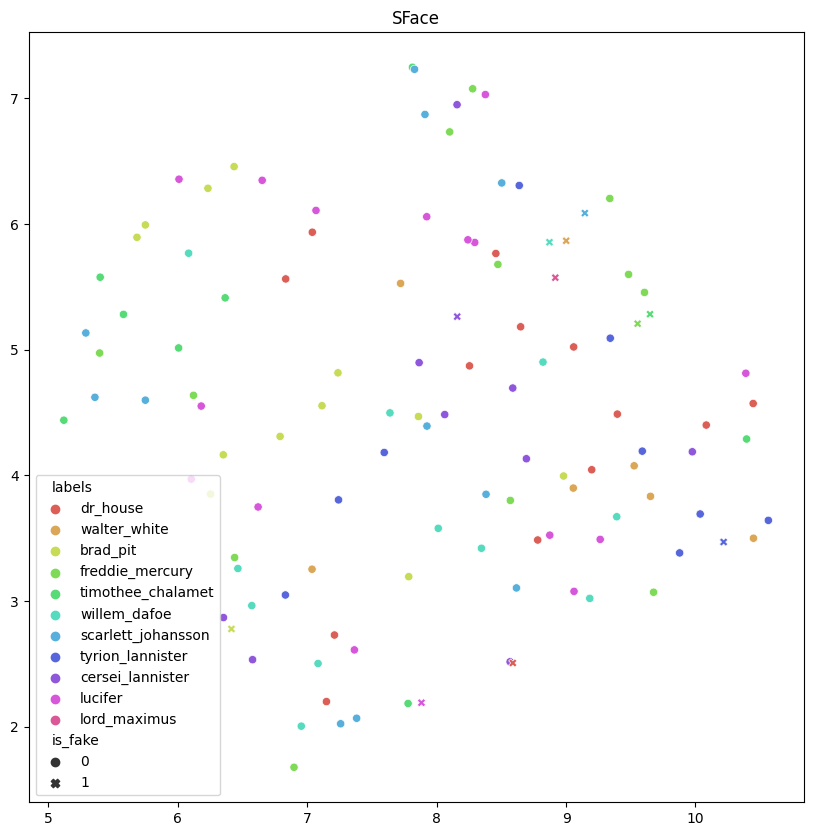

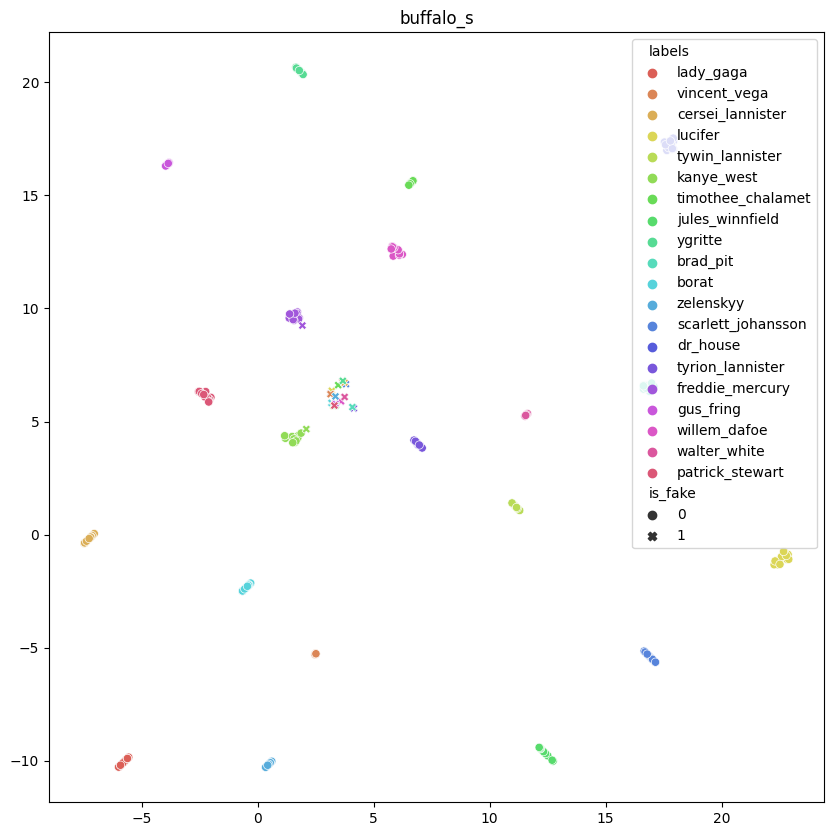

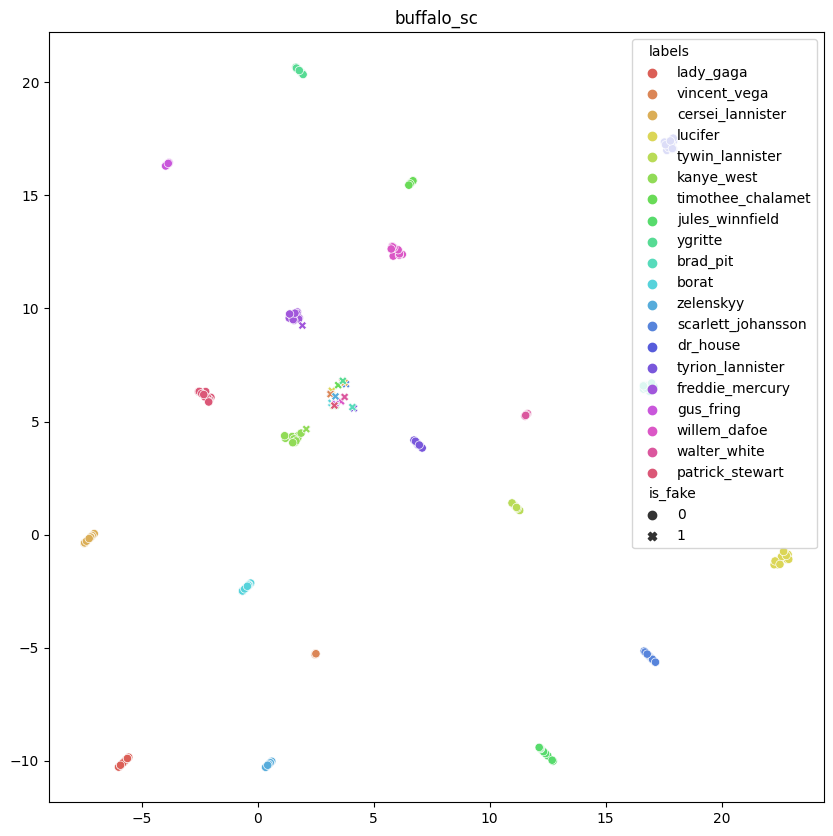

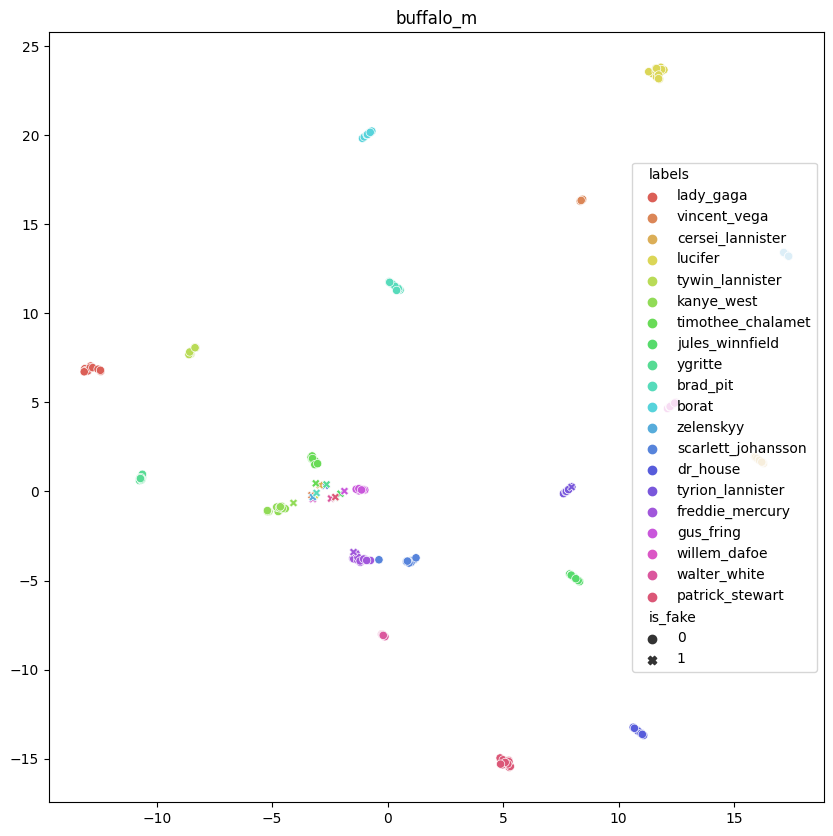

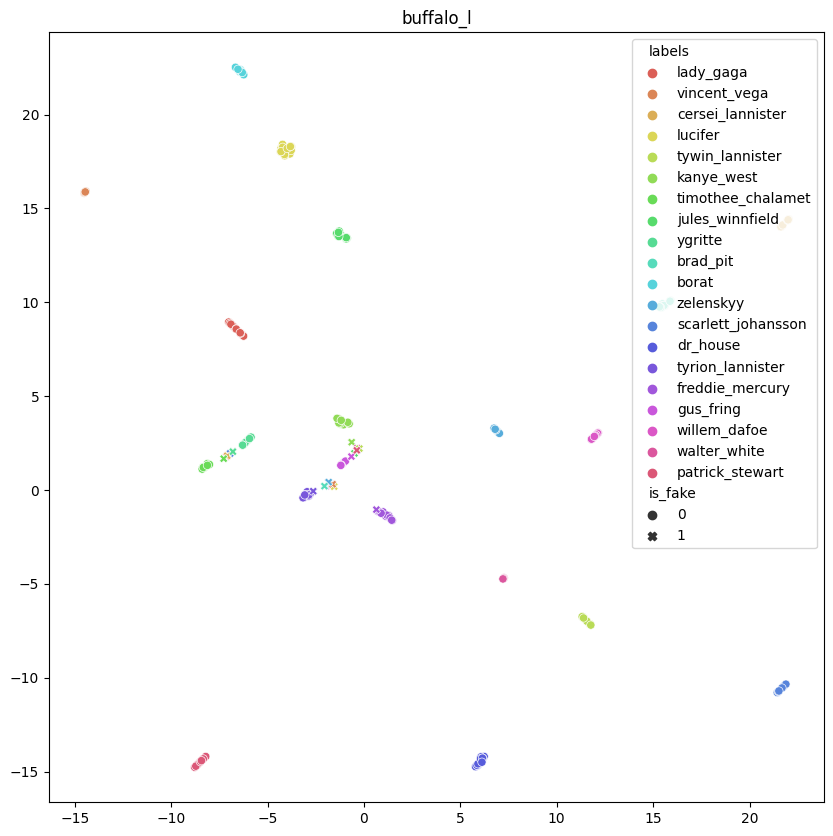

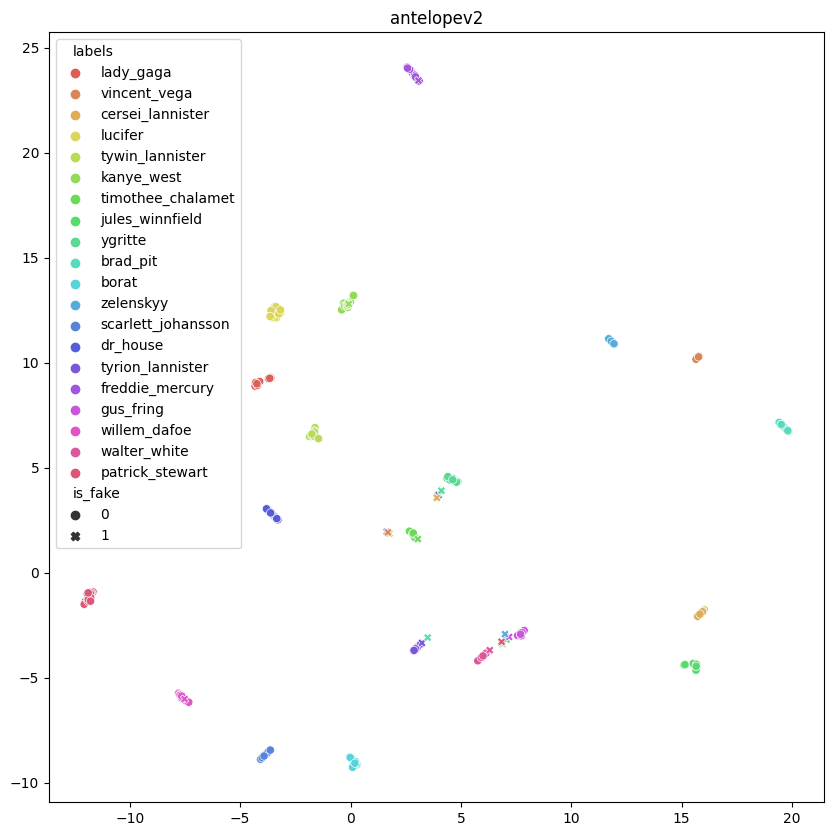

In [13]:
for model, umap_embedding in model2umap.items():
    plt.figure(figsize=(10, 10))
    sns.scatterplot(
        x=umap_embedding[:,0], y=umap_embedding[:,1],
        hue=model2df[model]["labels"],
        style=model2df[model]["is_fake"],
        palette=sns.color_palette("hls", len(model2df[model]["labels"].unique()))
    )
    plt.title(model)
    plt.show()

# Feature selection

borat


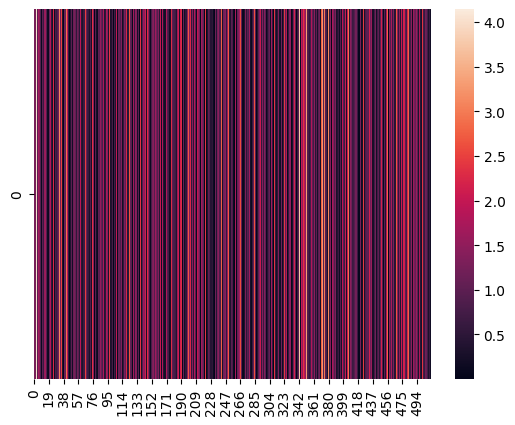

maximal variance for feature  442  is  1.121754239694273

brad_pit


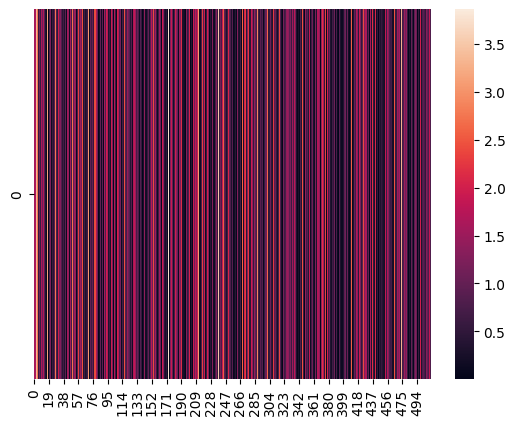

maximal variance for feature  508  is  1.3902055709168637

cersei_lannister


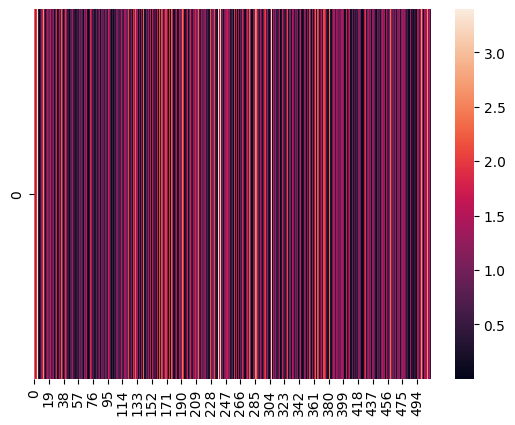

maximal variance for feature  19  is  0.9743580284572287

dr_house


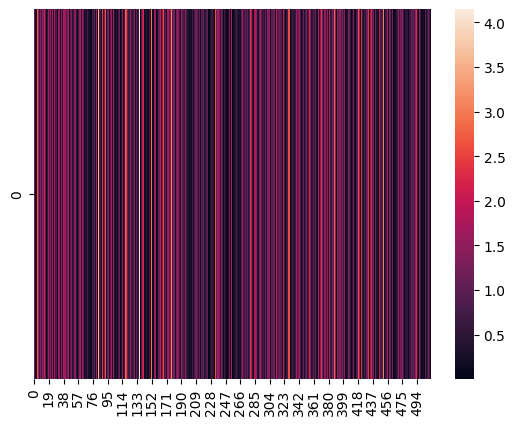

maximal variance for feature  357  is  0.8824837705464315

freddie_mercury


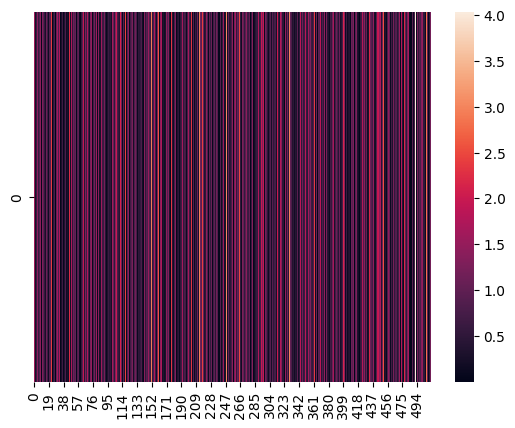

maximal variance for feature  409  is  1.3192594322838447

gus_fring


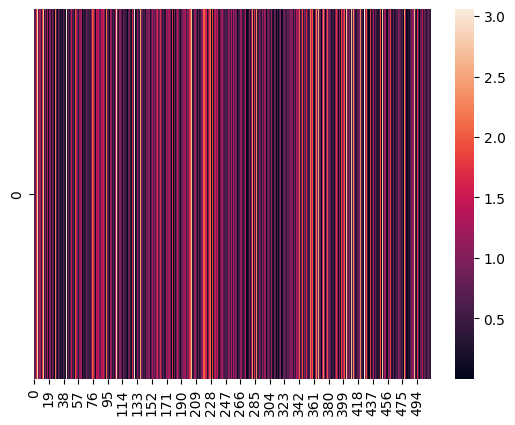

maximal variance for feature  202  is  2.051627527696665

jules_winnfield


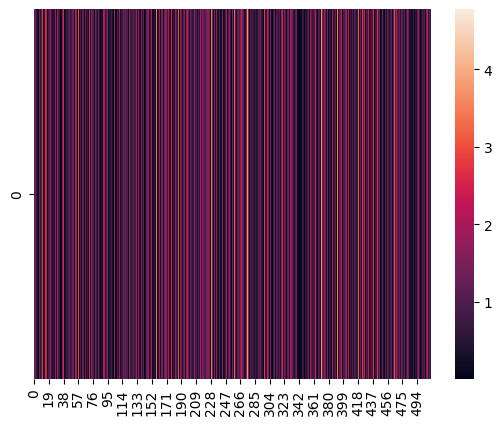

maximal variance for feature  336  is  1.3727458956568759

kanye_west


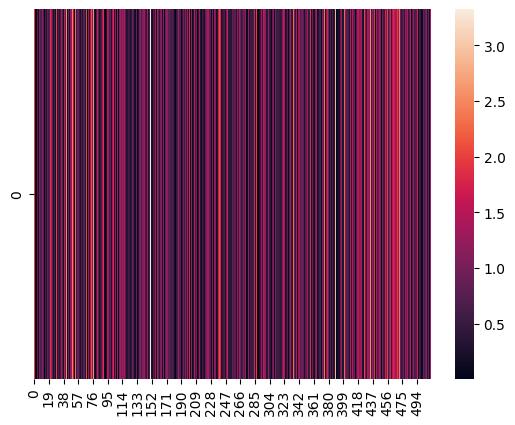

maximal variance for feature  63  is  0.8506952768326735

lady_gaga


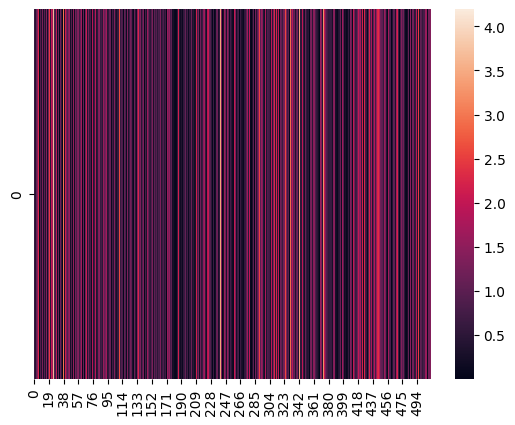

maximal variance for feature  495  is  1.6672342287703195

lucifer


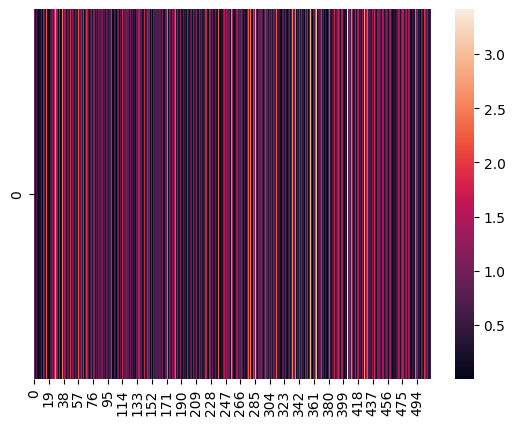

maximal variance for feature  123  is  1.1086272544946936

patrick_stewart


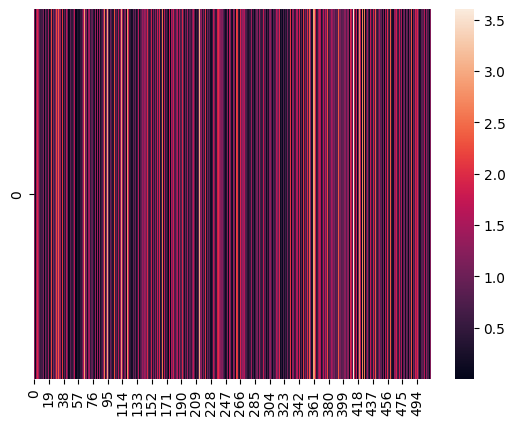

maximal variance for feature  429  is  0.9117469294050142

scarlett_johansson


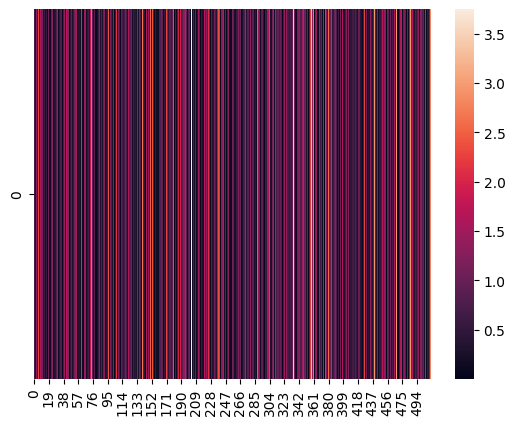

maximal variance for feature  59  is  1.0044693902856214

timothee_chalamet


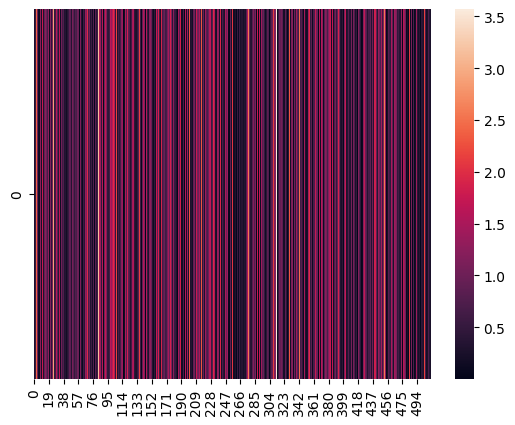

maximal variance for feature  415  is  0.9164446291952064

tyrion_lannister


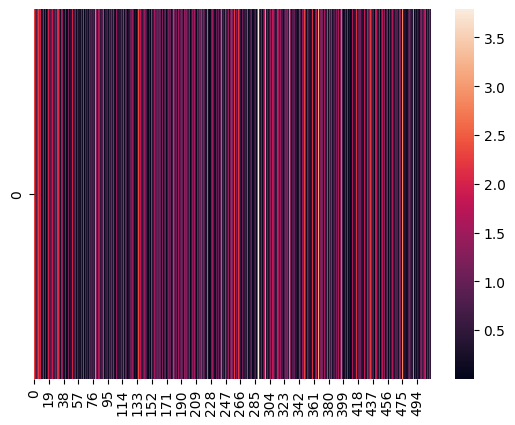

maximal variance for feature  80  is  1.5990585998350766

tywin_lannister


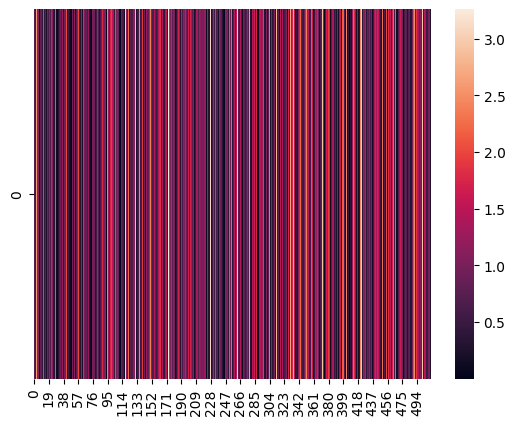

maximal variance for feature  494  is  1.0688325682352953

vincent_vega


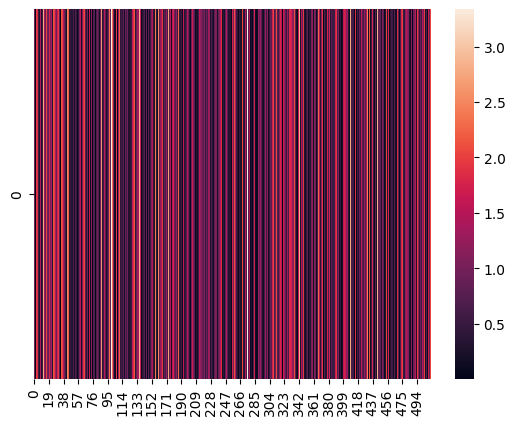

maximal variance for feature  89  is  1.996828188882347

walter_white


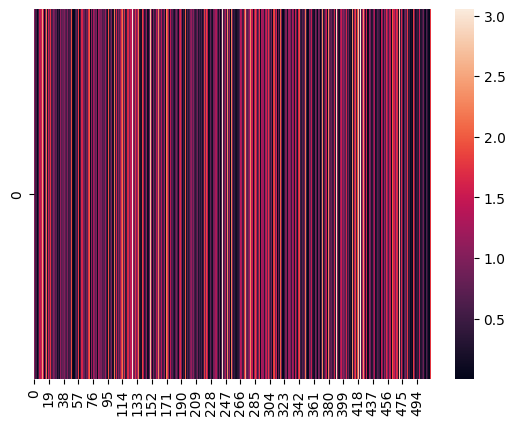

maximal variance for feature  41  is  1.4113231666107733

willem_dafoe


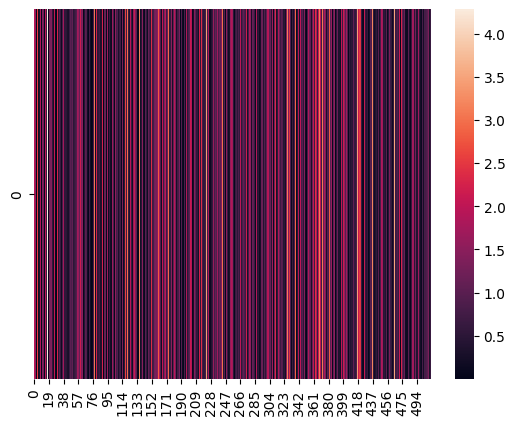

maximal variance for feature  475  is  0.8067332560604771

ygritte


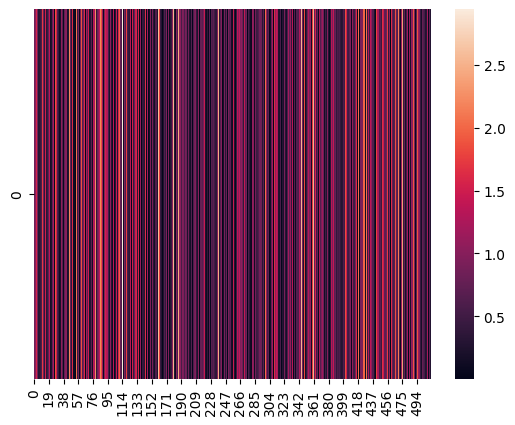

maximal variance for feature  100  is  1.10999672118251

zelenskyy


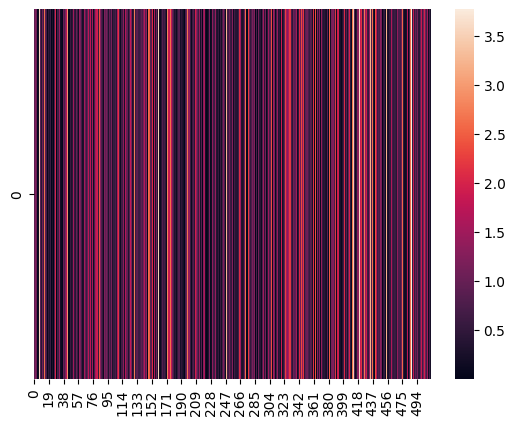

maximal variance for feature  141  is  1.4846813581849343



In [16]:
for label, features in model2df["buffalo_l"].groupby("labels"):
    print(label)
    X_real = np.array(features[features["is_fake"] == 0]["embeddings"].values.tolist())
    x_fake = np.array(features[features["is_fake"] == 1]["embeddings"].values.tolist())[0] # only one fake image per label
    diff = abs(X_real.mean(axis=0) - x_fake)
    sns.heatmap(diff.reshape(1, -1))
    plt.show()
    print("maximal variance for feature ", X_real.var(axis=0).argmax(), " is ", X_real.var(axis=0).max()) 
    print()